In [1]:
!pip install -f https://download.pytorch.org/whl/cu101/torch_stable.html torch==1.8.0+cu101 torchvision==0.9.0
!pip install wandb==0.12.1

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html


In [2]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2


In [3]:
!pip install scikit-learn

  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)


In [1]:
from tqdm import tqdm
from os import listdir
from random import *
seed(0)


import pandas as pd

from pylab import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:0"

## Data trepanation

In [3]:
dataset = 'labrador'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

len(train_files), len(val_files), len(test_files)

(1812, 366, 365)

In [4]:
keys = sample.keys()

In [5]:
def nan_check(tensor: torch.Tensor) -> bool:
    return True in tensor.isnan()

for key in keys:
    print(nan_check(sample[key]), key, sample[key].shape)

True cryosat.sic torch.Size([360, 500])
True cryosat.sit torch.Size([360, 500])
True jaxa.sic_asc torch.Size([360, 500])
True jaxa.sic_desc torch.Size([360, 500])
True jaxa.sic torch.Size([360, 500])
False gfs.f0d.temperature torch.Size([360, 500])
False gfs.f0d.pressure torch.Size([360, 500])
False gfs.f0d.wind_u torch.Size([360, 500])
False gfs.f0d.wind_v torch.Size([360, 500])
False gfs.f0d.wind torch.Size([360, 500])
False gfs.f1d.temperature torch.Size([360, 500])
False gfs.f1d.pressure torch.Size([360, 500])
False gfs.f1d.wind_u torch.Size([360, 500])
False gfs.f1d.wind_v torch.Size([360, 500])
False gfs.f1d.wind torch.Size([360, 500])
False gfs.f2d.temperature torch.Size([360, 500])
False gfs.f2d.pressure torch.Size([360, 500])
False gfs.f2d.wind_u torch.Size([360, 500])
False gfs.f2d.wind_v torch.Size([360, 500])
False gfs.f2d.wind torch.Size([360, 500])
False gfs.f3d.temperature torch.Size([360, 500])
False gfs.f3d.pressure torch.Size([360, 500])
False gfs.f3d.wind_u torch.Siz

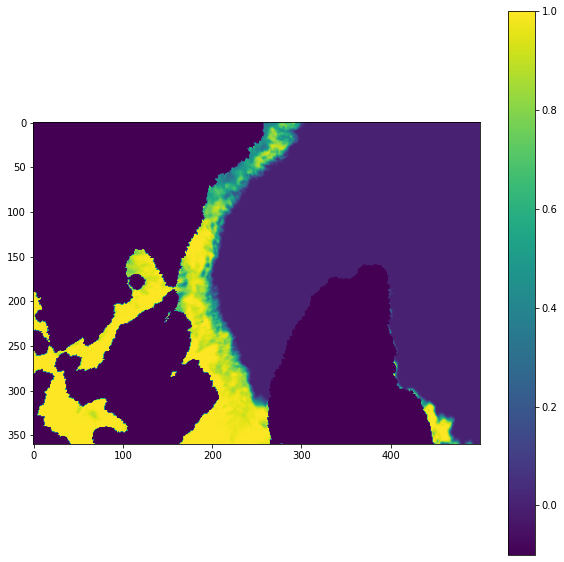

In [6]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0))/100 # + grid['land']*10

plt.figure(figsize=(10,10))
axs = imshow(preprocess_image(sample["jaxa.sic"]).reshape(360, 500).detach().cpu().numpy())
plt.colorbar()

In [7]:
images_train = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(train_files)))]
images_val = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(val_files)))]
images_test = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:04<00:00, 82.32it/s]


In [8]:
images_tensor_train, images_tensor_val, images_tensor_test = torch.stack(images_train).to(device),\
                                                             torch.stack(images_val).to(device),\
                                                             torch.stack(images_test).to(device)
images_tensor_train.shape

torch.Size([1812, 360, 500])

## Model trepanation

#### Check whether NaNs of the SIC part in the same positions or not

In [9]:
images_train_raw = [torch.load(folder_train + train_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(train_files)))]

images_val_raw = [torch.load(folder_val + val_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(val_files)))]

def handler(data: dict):
    try:
#        print(data["jaxa.sic"])
        return data["jaxa.sic"]
    except:
#        print(data["jaxa.sic_asc"])
        return data["jaxa.sic_asc"]
    
images_test_raw = [handler(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:14<00:00, 24.35it/s]


In [10]:
ref_mask = torch.isnan(images_train_raw[0])

diffs = []

for split in [images_train_raw, images_val_raw, images_test_raw]:
    data_2_check = [torch.logical_xor(torch.isnan(image), ref_mask) for image in split]
    diffs.append(data_2_check)

In [12]:
# ultimate mask correcions Labrador

diffs[2][181] = ~diffs[2][181]

diffs[0][987] = diffs[0][986]
diffs[0][1431] = diffs[0][1430]

In [13]:
from copy import deepcopy

ref_mask = torch.isnan(images_train_raw[0])
ultimate_mask = deepcopy(ref_mask)

for split in diffs:
    print('---')
    for i, image in enumerate(split[:]):
        if (torch.sum(image.float()) > 2*981.):
            print(i, torch.sum(image.float()))
        ultimate_mask = torch.logical_or(ultimate_mask, image)

---
---
---
181 tensor(85330.)


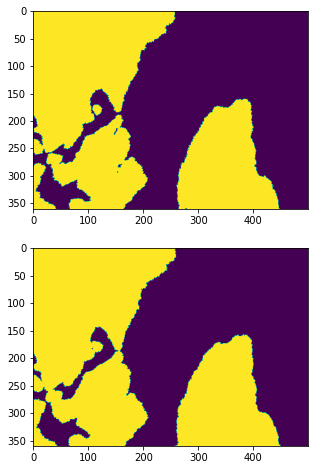

In [14]:
ref_mask = torch.isnan(images_train_raw[0])

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].imshow(ref_mask)
ax[1].imshow(ultimate_mask)
# plt.colorbar()

In [15]:
torch.save(ultimate_mask, 'mask_labrador.pt')

In [16]:
ultimate_mask = torch.load('mask_labrador.pt')

#### Actual experiments

In [14]:
epochs = 1000
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 5

In [84]:
images_in , images_out = load_data(batch_size, images_tensor_val, d_in, d_out)

images_in[:,-1][:, None, :, :].shape

torch.Size([8, 1, 360, 500])

In [85]:
test_output = model(images_in)
test_output.shape

torch.Size([8, 3, 360, 500])

In [97]:
sum_output_c = test_output + images_in[:,-1][:, None, :, :]
sum_output_n = test_output + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
test_output.shape

torch.Size([8, 3, 360, 500])

In [98]:
torch.all(sum_output_c == sum_output_n)

tensor(True, device='cuda:0')

In [87]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [ ]:
images_in

In [79]:
torch.all(images_in[:,-1] == images_in[:,-1][:, None, :, :].squeeze())

tensor(True, device='cuda:0')

In [83]:
images_in[0][0]

NameError: name 'images_in' is not defined

In [60]:
ultimate_mask[None, None, :].shape

torch.Size([1, 1, 360, 500])

In [98]:
ultimate_mask.to('cuda:0').shape

torch.Size([360, 500])

In [99]:
images_in[0][0].shape

torch.Size([360, 500])

TypeError: Invalid shape (75230,) for image data

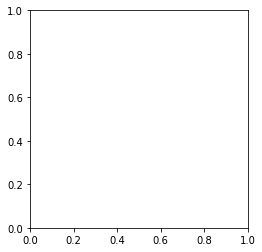

In [101]:
imshow(images_in[0][0].detach().cpu()[~ultimate_mask.cpu()])

In [23]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

def train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
#weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    for epoch in range(epochs):
        model.train()
        
        images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in) + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
        
        adapted_mask = ~ultimate_mask[None, None, :].repeat(batch_size,3,1,1)
        
        loss = criterion(model_out[adapted_mask], images_out[adapted_mask])
        loss.backward() # retain_graph=True
        
#        print(model_out.shape, images_out.shape)
        
        optimizer.step()
        
        if epoch % eval_step == 0:
            with torch.no_grad():
                model.eval()

                mae_total, rmse_total, mape_total = [], [], []

                total_test_len = len(images_tensor_test)
                start_point, steps = 0, int(total_test_len/(d_in + d_out))

                for i in range(steps):
                    images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                            images_tensor_test[start_point+d_in:start_point+d_in+d_out]

                    start_point += d_in + d_out

                   # model_out = images_in[-1][None, :, :].repeat(3, 1, 1)[None, :, : , :]
                    model_out = model(images_in[None, :, :, :]) + images_in[-1].repeat(3, 1, 1)[None, :, :, :] 

                    #                print(model_out.shape)
                
                    adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

                    loss_mse = criterion_mse(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])
                    loss_mae = criterion(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])

                    mae_total.append(loss_mae.detach().cpu().numpy())
                    rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
                wandb.log(
                    {
                     "test/test_MAE": average(mae_total), 
                     "test/test_RMSE": average(rmse_total)
                    }
                )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [24]:
torch.tensor([[1, 0], [0, 1]])[None, None, :].repeat(8,3, 1, 1)[0]

tensor([[[1, 0],
         [0, 1]],

        [[1, 0],
         [0, 1]],

        [[1, 0],
         [0, 1]]])

In [26]:
architecture = "UNet_7:3_per"
i = 0
wandb.init(project="initial_tests_RE_Labrador", entity="sea-ice-prediction", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

/home/jovyan/.imgenv-musing-bassi-0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/.imgenv-musing-bassi-0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/.imgenv-musing-bassi-0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/.imgenv-musing-bassi-0/lib/pyt

wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [27]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [28]:
from models.unet.unet.unet_model import UNet

epochs = 300
d_in, d_out = 7, 3
batch_size = 8
lr = 1e-3
eval_step = 1
criterion = nn.L1Loss()
model = UNet(d_in, d_out).to(device)

train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

Epoch  0 , test MAE -  0.07040881448321873
Epoch  1 , test MAE -  0.06381157371732923
Epoch  2 , test MAE -  0.05768264664544
Epoch  3 , test MAE -  0.05094003346231249
Epoch  4 , test MAE -  0.0475548075305091
Epoch  5 , test MAE -  0.04671922326087952
Epoch  6 , test MAE -  0.04594666759173075
Epoch  7 , test MAE -  0.046172791057162814
Epoch  8 , test MAE -  0.04627495341830783
Epoch  9 , test MAE -  0.04384651448991564
Epoch  10 , test MAE -  0.03623913725217184
Epoch  11 , test MAE -  0.030311405658721924
Epoch  12 , test MAE -  0.02945513857735528
Epoch  13 , test MAE -  0.030772570106718276
Epoch  14 , test MAE -  0.030319011873669095
Epoch  15 , test MAE -  0.029408431715435453
Epoch  16 , test MAE -  0.028466982973946467
Epoch  17 , test MAE -  0.02726230025291443
Epoch  18 , test MAE -  0.03020595841937595
Epoch  19 , test MAE -  0.031653016805648804
Epoch  20 , test MAE -  0.028780476914511785
Epoch  21 , test MAE -  0.02710276510980394
Epoch  22 , test MAE -  0.026447577608

Epoch  183 , test MAE -  0.019800843464003667
Epoch  184 , test MAE -  0.019471506277720135
Epoch  185 , test MAE -  0.018781511320008173
Epoch  186 , test MAE -  0.019448985656102497
Epoch  187 , test MAE -  0.020005744364526536
Epoch  188 , test MAE -  0.01980567475159963
Epoch  189 , test MAE -  0.01993863946861691
Epoch  190 , test MAE -  0.020015198323461745
Epoch  191 , test MAE -  0.019824581013785467
Epoch  192 , test MAE -  0.019720392094718084
Epoch  193 , test MAE -  0.01964884830845727
Epoch  194 , test MAE -  0.02008243567413754
Epoch  195 , test MAE -  0.020403037468592327
Epoch  196 , test MAE -  0.02013669080204434
Epoch  197 , test MAE -  0.0197297516796324
Epoch  198 , test MAE -  0.019197290142377216
Epoch  199 , test MAE -  0.019810847110218473
Epoch  200 , test MAE -  0.020128544833925035
Epoch  201 , test MAE -  0.01997910439968109
Epoch  202 , test MAE -  0.01949115428659651
Epoch  203 , test MAE -  0.01955744955274794
Epoch  204 , test MAE -  0.01986543834209442

In [29]:
epochs = 3200
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-4, eval_step)

Epoch  0 , test MAE -  0.020681775278515287
Epoch  1 , test MAE -  0.020983874797821045
Epoch  2 , test MAE -  0.02081124981244405
Epoch  3 , test MAE -  0.02052748699982961
Epoch  4 , test MAE -  0.02004215617974599
Epoch  5 , test MAE -  0.01967019670539432
Epoch  6 , test MAE -  0.01953649686442481
Epoch  7 , test MAE -  0.019601821899414062
Epoch  8 , test MAE -  0.019578930404451158
Epoch  9 , test MAE -  0.019468491276105244
Epoch  10 , test MAE -  0.019310484329859417
Epoch  11 , test MAE -  0.0192691617541843
Epoch  12 , test MAE -  0.019330701894230314
Epoch  13 , test MAE -  0.019217572278446622
Epoch  14 , test MAE -  0.019144250286950007
Epoch  15 , test MAE -  0.018992957141664293
Epoch  16 , test MAE -  0.018878036075168185
Epoch  17 , test MAE -  0.01881576081116994
Epoch  18 , test MAE -  0.01879144873883989
Epoch  19 , test MAE -  0.018744627634684246
Epoch  20 , test MAE -  0.018736786312527128
Epoch  21 , test MAE -  0.01868276960319943
Epoch  22 , test MAE -  0.0186

Epoch  183 , test MAE -  0.01882559723324246
Epoch  184 , test MAE -  0.0186636530690723
Epoch  185 , test MAE -  0.01857312023639679
Epoch  186 , test MAE -  0.018612792094548542
Epoch  187 , test MAE -  0.018771270910898846
Epoch  188 , test MAE -  0.018797157539261714
Epoch  189 , test MAE -  0.018838751647207472
Epoch  190 , test MAE -  0.01877239677641127
Epoch  191 , test MAE -  0.018639587693744235
Epoch  192 , test MAE -  0.018594405717319913
Epoch  193 , test MAE -  0.018644783231947158
Epoch  194 , test MAE -  0.0187985897064209
Epoch  195 , test MAE -  0.018913067049450345
Epoch  196 , test MAE -  0.01895684500535329
Epoch  197 , test MAE -  0.018950437506039936
Epoch  198 , test MAE -  0.018933147192001343
Epoch  199 , test MAE -  0.01905627217557695
Epoch  200 , test MAE -  0.019282422131962247
Epoch  201 , test MAE -  0.019365438156657748
Epoch  202 , test MAE -  0.019254866573545668
Epoch  203 , test MAE -  0.019014270769225225
Epoch  204 , test MAE -  0.0188657045364379

Epoch  363 , test MAE -  0.01824363734987047
Epoch  364 , test MAE -  0.01825293567445543
Epoch  365 , test MAE -  0.018282193276617262
Epoch  366 , test MAE -  0.018294091025988262
Epoch  367 , test MAE -  0.018294925491015118
Epoch  368 , test MAE -  0.018279348810513813
Epoch  369 , test MAE -  0.018279070655504864
Epoch  370 , test MAE -  0.018411245610978868
Epoch  371 , test MAE -  0.018374441398514643
Epoch  372 , test MAE -  0.01838760409090254
Epoch  373 , test MAE -  0.018370042244593304
Epoch  374 , test MAE -  0.018390549553765193
Epoch  375 , test MAE -  0.01840362615055508
Epoch  376 , test MAE -  0.018422346976068284
Epoch  377 , test MAE -  0.018423042363590665
Epoch  378 , test MAE -  0.018442786402172513
Epoch  379 , test MAE -  0.01861262321472168
Epoch  380 , test MAE -  0.018898268540700276
Epoch  381 , test MAE -  0.019022352165646024
Epoch  382 , test MAE -  0.01899572213490804
Epoch  383 , test MAE -  0.018813411394755047
Epoch  384 , test MAE -  0.0186441921525

Epoch  543 , test MAE -  0.01820442411634657
Epoch  544 , test MAE -  0.018320716089672513
Epoch  545 , test MAE -  0.018419848548041448
Epoch  546 , test MAE -  0.01847576101620992
Epoch  547 , test MAE -  0.018469787306255765
Epoch  548 , test MAE -  0.01841114626990424
Epoch  549 , test MAE -  0.0183083928293652
Epoch  550 , test MAE -  0.018199889196289912
Epoch  551 , test MAE -  0.018172633316781785
Epoch  552 , test MAE -  0.018195276459058125
Epoch  553 , test MAE -  0.018236254652341206
Epoch  554 , test MAE -  0.01821014119519128
Epoch  555 , test MAE -  0.018081199791696336
Epoch  556 , test MAE -  0.018072711096869573
Epoch  557 , test MAE -  0.018190690212779574
Epoch  558 , test MAE -  0.018259702457322016
Epoch  559 , test MAE -  0.018236807650989957
Epoch  560 , test MAE -  0.01813629104031457
Epoch  561 , test MAE -  0.0180392497115665
Epoch  562 , test MAE -  0.01800837947262658
Epoch  563 , test MAE -  0.018145528104570176
Epoch  564 , test MAE -  0.01826078858640458

Epoch  723 , test MAE -  0.01779518524805705
Epoch  724 , test MAE -  0.01780318220456441
Epoch  725 , test MAE -  0.017780280775494046
Epoch  726 , test MAE -  0.017764104737175837
Epoch  727 , test MAE -  0.01774138377772437
Epoch  728 , test MAE -  0.01772483189900716
Epoch  729 , test MAE -  0.017734391821755305
Epoch  730 , test MAE -  0.017757715450392828
Epoch  731 , test MAE -  0.017832901742723253
Epoch  732 , test MAE -  0.017849634091059368
Epoch  733 , test MAE -  0.017859861254692078
Epoch  734 , test MAE -  0.01779770851135254
Epoch  735 , test MAE -  0.01775329311688741
Epoch  736 , test MAE -  0.017679029040866427
Epoch  737 , test MAE -  0.017626259062025283
Epoch  738 , test MAE -  0.017552039689487882
Epoch  739 , test MAE -  0.01765634450647566
Epoch  740 , test MAE -  0.01770742403136359
Epoch  741 , test MAE -  0.017653480172157288
Epoch  742 , test MAE -  0.017654773261811998
Epoch  743 , test MAE -  0.017744349108801946
Epoch  744 , test MAE -  0.017762881186273

Epoch  903 , test MAE -  0.017530820435947843
Epoch  904 , test MAE -  0.01752691964308421
Epoch  905 , test MAE -  0.017553991741604276
Epoch  906 , test MAE -  0.017521457539664373
Epoch  907 , test MAE -  0.017512672477298312
Epoch  908 , test MAE -  0.01747803721163008
Epoch  909 , test MAE -  0.01742700735727946
Epoch  910 , test MAE -  0.017466682526800368
Epoch  911 , test MAE -  0.017566192481252883
Epoch  912 , test MAE -  0.017701390716764662
Epoch  913 , test MAE -  0.017865959140989516
Epoch  914 , test MAE -  0.0178259594572915
Epoch  915 , test MAE -  0.017754920654826693
Epoch  916 , test MAE -  0.017871444423993427
Epoch  917 , test MAE -  0.017966743972566392
Epoch  918 , test MAE -  0.01788286202483707
Epoch  919 , test MAE -  0.017780787414974637
Epoch  920 , test MAE -  0.017705712053510878
Epoch  921 , test MAE -  0.017652069528897602
Epoch  922 , test MAE -  0.017627163065804377
Epoch  923 , test MAE -  0.017721700999471877
Epoch  924 , test MAE -  0.0176485859685

Epoch  1081 , test MAE -  0.01771163112587399
Epoch  1082 , test MAE -  0.017894135581122503
Epoch  1083 , test MAE -  0.0181025978591707
Epoch  1084 , test MAE -  0.017723061972194247
Epoch  1085 , test MAE -  0.01758419970671336
Epoch  1086 , test MAE -  0.017577573657035828
Epoch  1087 , test MAE -  0.017587340540356107
Epoch  1088 , test MAE -  0.017607064710723028
Epoch  1089 , test MAE -  0.017629327045546636
Epoch  1090 , test MAE -  0.017585996124479506
Epoch  1091 , test MAE -  0.017541956570413377
Epoch  1092 , test MAE -  0.017511496941248577
Epoch  1093 , test MAE -  0.017445685134993658
Epoch  1094 , test MAE -  0.017422583368089464
Epoch  1095 , test MAE -  0.01747290293375651
Epoch  1096 , test MAE -  0.017564588122897677
Epoch  1097 , test MAE -  0.01764893862936232
Epoch  1098 , test MAE -  0.017699991663297016
Epoch  1099 , test MAE -  0.017750392357508343
Epoch  1100 , test MAE -  0.017775530616442364
Epoch  1101 , test MAE -  0.017713917626274958
Epoch  1102 , test 

Epoch  1257 , test MAE -  0.018049673901663885
Epoch  1258 , test MAE -  0.01808425121837192
Epoch  1259 , test MAE -  0.01803175277180142
Epoch  1260 , test MAE -  0.017911718951331243
Epoch  1261 , test MAE -  0.0177530695994695
Epoch  1262 , test MAE -  0.017580048905478582
Epoch  1263 , test MAE -  0.01745801005098555
Epoch  1264 , test MAE -  0.017385229468345642
Epoch  1265 , test MAE -  0.01740885277589162
Epoch  1266 , test MAE -  0.01730900506178538
Epoch  1267 , test MAE -  0.01728540990087721
Epoch  1268 , test MAE -  0.01739836401409573
Epoch  1269 , test MAE -  0.017506842811902363
Epoch  1270 , test MAE -  0.01764903465906779
Epoch  1271 , test MAE -  0.017727245887120564
Epoch  1272 , test MAE -  0.017661806609895494
Epoch  1273 , test MAE -  0.017610664168993633
Epoch  1274 , test MAE -  0.017598496543036565
Epoch  1275 , test MAE -  0.017617113060421415
Epoch  1276 , test MAE -  0.01765035589536031
Epoch  1277 , test MAE -  0.01767007675435808
Epoch  1278 , test MAE - 

Epoch  1433 , test MAE -  0.017320397827360366
Epoch  1434 , test MAE -  0.01737258831659953
Epoch  1435 , test MAE -  0.017351678676075406
Epoch  1436 , test MAE -  0.017261748512585957
Epoch  1437 , test MAE -  0.017181239194340177
Epoch  1438 , test MAE -  0.01711694896221161
Epoch  1439 , test MAE -  0.01709617508782281
Epoch  1440 , test MAE -  0.017091140151023865
Epoch  1441 , test MAE -  0.017150632209248014
Epoch  1442 , test MAE -  0.017216394344965618
Epoch  1443 , test MAE -  0.017274075084262423
Epoch  1444 , test MAE -  0.01731867591540019
Epoch  1445 , test MAE -  0.017329530583487615
Epoch  1446 , test MAE -  0.0173025561703576
Epoch  1447 , test MAE -  0.017241112060017057
Epoch  1448 , test MAE -  0.01728404892815484
Epoch  1449 , test MAE -  0.017287173204951815
Epoch  1450 , test MAE -  0.01729592846499549
Epoch  1451 , test MAE -  0.017283648252487183
Epoch  1452 , test MAE -  0.017277669575479295
Epoch  1453 , test MAE -  0.017261420687039692
Epoch  1454 , test MA

Epoch  1609 , test MAE -  0.017024172676934138
Epoch  1610 , test MAE -  0.017101663682195876
Epoch  1611 , test MAE -  0.017192305790053472
Epoch  1612 , test MAE -  0.017165140973197088
Epoch  1613 , test MAE -  0.01711896558602651
Epoch  1614 , test MAE -  0.017100175221761067
Epoch  1615 , test MAE -  0.017032954427931044
Epoch  1616 , test MAE -  0.017010794745551214
Epoch  1617 , test MAE -  0.01692123379972246
Epoch  1618 , test MAE -  0.016896097196473017
Epoch  1619 , test MAE -  0.01694014999601576
Epoch  1620 , test MAE -  0.017029484113057453
Epoch  1621 , test MAE -  0.017201877302593656
Epoch  1622 , test MAE -  0.01737199392583635
Epoch  1623 , test MAE -  0.017400349179903667
Epoch  1624 , test MAE -  0.01733327243063185
Epoch  1625 , test MAE -  0.017176856597264607
Epoch  1626 , test MAE -  0.017140545778804354
Epoch  1627 , test MAE -  0.017350289556715224
Epoch  1628 , test MAE -  0.017670939366022747
Epoch  1629 , test MAE -  0.017179098394181993
Epoch  1630 , test

Epoch  1785 , test MAE -  0.01678104864226447
Epoch  1786 , test MAE -  0.016889058881335788
Epoch  1787 , test MAE -  0.01699160701698727
Epoch  1788 , test MAE -  0.017013740208413865
Epoch  1789 , test MAE -  0.016999743050999112
Epoch  1790 , test MAE -  0.016984664731555514
Epoch  1791 , test MAE -  0.016978262199295893
Epoch  1792 , test MAE -  0.016971828209029302
Epoch  1793 , test MAE -  0.016972452402114868
Epoch  1794 , test MAE -  0.016966170734829374
Epoch  1795 , test MAE -  0.016932057009802923
Epoch  1796 , test MAE -  0.01689263681570689
Epoch  1797 , test MAE -  0.01677200694878896
Epoch  1798 , test MAE -  0.016761008236143324
Epoch  1799 , test MAE -  0.016808008154233296
Epoch  1800 , test MAE -  0.016883626580238342
Epoch  1801 , test MAE -  0.016953011353810627
Epoch  1802 , test MAE -  0.016935373346010845
Epoch  1803 , test MAE -  0.016951517926322088
Epoch  1804 , test MAE -  0.016915528310669795
Epoch  1805 , test MAE -  0.016874964038530987
Epoch  1806 , tes

Epoch  1961 , test MAE -  0.016602433390087552
Epoch  1962 , test MAE -  0.016579179300202265
Epoch  1963 , test MAE -  0.01661344865957896
Epoch  1964 , test MAE -  0.016691573792033725
Epoch  1965 , test MAE -  0.01678513487180074
Epoch  1966 , test MAE -  0.01684901283846961
Epoch  1967 , test MAE -  0.016899373796251085
Epoch  1968 , test MAE -  0.01699749794271257
Epoch  1969 , test MAE -  0.016820248630311754
Epoch  1970 , test MAE -  0.01686554319328732
Epoch  1971 , test MAE -  0.01690139373143514
Epoch  1972 , test MAE -  0.01689607898394267
Epoch  1973 , test MAE -  0.016964960429403517
Epoch  1974 , test MAE -  0.01692999733818902
Epoch  1975 , test MAE -  0.016870702306429546
Epoch  1976 , test MAE -  0.016780311862627666
Epoch  1977 , test MAE -  0.016732166210810345
Epoch  1978 , test MAE -  0.016705185174942017
Epoch  1979 , test MAE -  0.01675201952457428
Epoch  1980 , test MAE -  0.016755521297454834
Epoch  1981 , test MAE -  0.016786307096481323
Epoch  1982 , test MAE

Epoch  2137 , test MAE -  0.016715839505195618
Epoch  2138 , test MAE -  0.01678335666656494
Epoch  2139 , test MAE -  0.0168294757604599
Epoch  2140 , test MAE -  0.016859701938099332
Epoch  2141 , test MAE -  0.01684240996837616
Epoch  2142 , test MAE -  0.016781760586632624
Epoch  2143 , test MAE -  0.0166975027985043
Epoch  2144 , test MAE -  0.016619930664698284
Epoch  2145 , test MAE -  0.01658616794480218
Epoch  2146 , test MAE -  0.01662386291556888
Epoch  2147 , test MAE -  0.016727311743630305
Epoch  2148 , test MAE -  0.01682993272940318
Epoch  2149 , test MAE -  0.0169117185804579
Epoch  2150 , test MAE -  0.016967076394293044
Epoch  2151 , test MAE -  0.017071305049790278
Epoch  2152 , test MAE -  0.017121440834469266
Epoch  2153 , test MAE -  0.017196534408463374
Epoch  2154 , test MAE -  0.017254751589563157
Epoch  2155 , test MAE -  0.017369260390599568
Epoch  2156 , test MAE -  0.017345759603712294
Epoch  2157 , test MAE -  0.01725337240431044
Epoch  2158 , test MAE - 

Epoch  2313 , test MAE -  0.016738745901319716
Epoch  2314 , test MAE -  0.016700986358854506
Epoch  2315 , test MAE -  0.016683369874954224
Epoch  2316 , test MAE -  0.016702165206273396
Epoch  2317 , test MAE -  0.016704971591631573
Epoch  2318 , test MAE -  0.01671094364590115
Epoch  2319 , test MAE -  0.01677432159582774
Epoch  2320 , test MAE -  0.016776036885049608
Epoch  2321 , test MAE -  0.01672165592511495
Epoch  2322 , test MAE -  0.016687038871977065
Epoch  2323 , test MAE -  0.016709537969695196
Epoch  2324 , test MAE -  0.016759915484322443
Epoch  2325 , test MAE -  0.01682475871509976
Epoch  2326 , test MAE -  0.01689349114894867
Epoch  2327 , test MAE -  0.016894148455725774
Epoch  2328 , test MAE -  0.01691728499200609
Epoch  2329 , test MAE -  0.016843108667267695
Epoch  2330 , test MAE -  0.01671425501505534
Epoch  2331 , test MAE -  0.016633035408125982
Epoch  2332 , test MAE -  0.016569879319932725
Epoch  2333 , test MAE -  0.01653831038210127
Epoch  2334 , test MA

Epoch  2489 , test MAE -  0.01680501964357164
Epoch  2490 , test MAE -  0.016792858640352886
Epoch  2491 , test MAE -  0.016751185059547424
Epoch  2492 , test MAE -  0.01671975188785129
Epoch  2493 , test MAE -  0.01671404308742947
Epoch  2494 , test MAE -  0.01669788360595703
Epoch  2495 , test MAE -  0.016651891999774508
Epoch  2496 , test MAE -  0.016548509399096172
Epoch  2497 , test MAE -  0.016538110044267442
Epoch  2498 , test MAE -  0.01654247608449724
Epoch  2499 , test MAE -  0.016576157675849065
Epoch  2500 , test MAE -  0.016630109813478258
Epoch  2501 , test MAE -  0.016681449280844793
Epoch  2502 , test MAE -  0.016672874490420025
Epoch  2503 , test MAE -  0.0165534731414583
Epoch  2504 , test MAE -  0.016433290309376188
Epoch  2505 , test MAE -  0.016343555516666837
Epoch  2506 , test MAE -  0.01628907687134213
Epoch  2507 , test MAE -  0.016347487767537434
Epoch  2508 , test MAE -  0.01639350752035777
Epoch  2509 , test MAE -  0.01640086703830295
Epoch  2510 , test MAE 

Epoch  2665 , test MAE -  0.01673849258157942
Epoch  2666 , test MAE -  0.016802567574712966
Epoch  2667 , test MAE -  0.016816943883895874
Epoch  2668 , test MAE -  0.01681664917204115
Epoch  2669 , test MAE -  0.01681498024198744
Epoch  2670 , test MAE -  0.016780722472402785
Epoch  2671 , test MAE -  0.0167328053050571
Epoch  2672 , test MAE -  0.016696444816059537
Epoch  2673 , test MAE -  0.016651189989513822
Epoch  2674 , test MAE -  0.016617523299323186
Epoch  2675 , test MAE -  0.016569453808996413
Epoch  2676 , test MAE -  0.016534565223587885
Epoch  2677 , test MAE -  0.016668644216325548
Epoch  2678 , test MAE -  0.016877785325050354
Epoch  2679 , test MAE -  0.01713702744907803
Epoch  2680 , test MAE -  0.017300211720996432
Epoch  2681 , test MAE -  0.017254069447517395
Epoch  2682 , test MAE -  0.017143724693192378
Epoch  2683 , test MAE -  0.01696122686068217
Epoch  2684 , test MAE -  0.016829086674584284
Epoch  2685 , test MAE -  0.016743219561047025
Epoch  2686 , test M

Epoch  2841 , test MAE -  0.01649176412158542
Epoch  2842 , test MAE -  0.016484131415685017
Epoch  2843 , test MAE -  0.016466667254765827
Epoch  2844 , test MAE -  0.016428629557291668
Epoch  2845 , test MAE -  0.016485939423243206
Epoch  2846 , test MAE -  0.01650005082289378
Epoch  2847 , test MAE -  0.016507945126957364
Epoch  2848 , test MAE -  0.0165117084980011
Epoch  2849 , test MAE -  0.016509781281153362
Epoch  2850 , test MAE -  0.0165206061469184
Epoch  2851 , test MAE -  0.01659301585621304
Epoch  2852 , test MAE -  0.016661340991655987
Epoch  2853 , test MAE -  0.0166966931687461
Epoch  2854 , test MAE -  0.016758814454078674
Epoch  2855 , test MAE -  0.016808897256851196
Epoch  2856 , test MAE -  0.016795292496681213
Epoch  2857 , test MAE -  0.016800580753220454
Epoch  2858 , test MAE -  0.016781828469700284
Epoch  2859 , test MAE -  0.016744724578327604
Epoch  2860 , test MAE -  0.01676900353696611
Epoch  2861 , test MAE -  0.016814094450738695
Epoch  2862 , test MAE 

Epoch  3017 , test MAE -  0.01629766821861267
Epoch  3018 , test MAE -  0.016328546735975478
Epoch  3019 , test MAE -  0.01633412970436944
Epoch  3020 , test MAE -  0.016296429766549006
Epoch  3021 , test MAE -  0.0162546220752928
Epoch  3022 , test MAE -  0.016206449932522245
Epoch  3023 , test MAE -  0.01620735228061676
Epoch  3024 , test MAE -  0.01624822451008691
Epoch  3025 , test MAE -  0.016323130991723802
Epoch  3026 , test MAE -  0.016342388259039983
Epoch  3027 , test MAE -  0.01630310383107927
Epoch  3028 , test MAE -  0.016265067789289687
Epoch  3029 , test MAE -  0.016257075799836054
Epoch  3030 , test MAE -  0.016248260935147602
Epoch  3031 , test MAE -  0.016284970773590937
Epoch  3032 , test MAE -  0.0163489431142807
Epoch  3033 , test MAE -  0.016418649090660944
Epoch  3034 , test MAE -  0.01645832426018185
Epoch  3035 , test MAE -  0.016414885719617207
Epoch  3036 , test MAE -  0.01638869610097673
Epoch  3037 , test MAE -  0.016364203559027776
Epoch  3038 , test MAE -

Epoch  3194 , test MAE -  0.016421576340993244
Epoch  3195 , test MAE -  0.01645097302065955
Epoch  3196 , test MAE -  0.01657254993915558
Epoch  3197 , test MAE -  0.016626162661446467
Epoch  3198 , test MAE -  0.016704372233814664
Epoch  3199 , test MAE -  0.01669026083416409


In [30]:
epochs = 5000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-5, eval_step)

Epoch  0 , test MAE -  0.016592158211602107
Epoch  1 , test MAE -  0.016478995482126873
Epoch  2 , test MAE -  0.016455751326349046
Epoch  3 , test MAE -  0.016395855281088088
Epoch  4 , test MAE -  0.01632756491502126
Epoch  5 , test MAE -  0.016277285085784063
Epoch  6 , test MAE -  0.016261067655351426
Epoch  7 , test MAE -  0.01624683870209588
Epoch  8 , test MAE -  0.01622996727625529
Epoch  9 , test MAE -  0.016207651959525213
Epoch  10 , test MAE -  0.016170769929885864
Epoch  11 , test MAE -  0.016136503881878324
Epoch  12 , test MAE -  0.01611765722433726
Epoch  13 , test MAE -  0.016102784209781222
Epoch  14 , test MAE -  0.016088508897357516
Epoch  15 , test MAE -  0.01609131693840027
Epoch  16 , test MAE -  0.016090845068295796
Epoch  17 , test MAE -  0.01610040499104394
Epoch  18 , test MAE -  0.016090288758277893
Epoch  19 , test MAE -  0.01607551011774275
Epoch  20 , test MAE -  0.016079093019167583
Epoch  21 , test MAE -  0.016074015034569636
Epoch  22 , test MAE -  0.0

Epoch  183 , test MAE -  0.015912696719169617
Epoch  184 , test MAE -  0.015920317835277982
Epoch  185 , test MAE -  0.01591042677561442
Epoch  186 , test MAE -  0.01591550310452779
Epoch  187 , test MAE -  0.015909330712424383
Epoch  188 , test MAE -  0.015899552239312068
Epoch  189 , test MAE -  0.015888305173979864
Epoch  190 , test MAE -  0.015888614786995783
Epoch  191 , test MAE -  0.015883256991704304
Epoch  192 , test MAE -  0.015881152616606817
Epoch  193 , test MAE -  0.015885712371932134
Epoch  194 , test MAE -  0.015887608130772907
Epoch  195 , test MAE -  0.015894280539618597
Epoch  196 , test MAE -  0.015902413262261286
Epoch  197 , test MAE -  0.015909410185284086
Epoch  198 , test MAE -  0.01591083076265123
Epoch  199 , test MAE -  0.01589505871136983
Epoch  200 , test MAE -  0.015890846649805706
Epoch  201 , test MAE -  0.015892644723256428
Epoch  202 , test MAE -  0.015911762913068134
Epoch  203 , test MAE -  0.015901654958724976
Epoch  204 , test MAE -  0.01589251889

Epoch  363 , test MAE -  0.015946777330504522
Epoch  364 , test MAE -  0.015896639890140958
Epoch  365 , test MAE -  0.015876500142945185
Epoch  366 , test MAE -  0.015913557675149705
Epoch  367 , test MAE -  0.015895093480745952
Epoch  368 , test MAE -  0.015881386068132188
Epoch  369 , test MAE -  0.015897843572828505
Epoch  370 , test MAE -  0.015935371319452923
Epoch  371 , test MAE -  0.015938035315937467
Epoch  372 , test MAE -  0.01593002676963806
Epoch  373 , test MAE -  0.015916658772362605
Epoch  374 , test MAE -  0.015905297464794584
Epoch  375 , test MAE -  0.015893674559063382
Epoch  376 , test MAE -  0.015909146931436326
Epoch  377 , test MAE -  0.01591263214747111
Epoch  378 , test MAE -  0.015910678439670138
Epoch  379 , test MAE -  0.015931255287594266
Epoch  380 , test MAE -  0.015923420588175457
Epoch  381 , test MAE -  0.015939364830652874
Epoch  382 , test MAE -  0.015922715266545612
Epoch  383 , test MAE -  0.015905974639786616
Epoch  384 , test MAE -  0.015883487

Epoch  543 , test MAE -  0.015942310293515522
Epoch  544 , test MAE -  0.015935114688343473
Epoch  545 , test MAE -  0.01591722501648797
Epoch  546 , test MAE -  0.015915653771824308
Epoch  547 , test MAE -  0.01589286658498976
Epoch  548 , test MAE -  0.015879589650366042
Epoch  549 , test MAE -  0.01587533288531833
Epoch  550 , test MAE -  0.01586035556263394
Epoch  551 , test MAE -  0.01585575772656335
Epoch  552 , test MAE -  0.015856886903444927
Epoch  553 , test MAE -  0.015863802697923448
Epoch  554 , test MAE -  0.015865085853470698
Epoch  555 , test MAE -  0.01585337022940318
Epoch  556 , test MAE -  0.01584613819917043
Epoch  557 , test MAE -  0.01583133141199748
Epoch  558 , test MAE -  0.015838525361484952
Epoch  559 , test MAE -  0.01583403514491187
Epoch  560 , test MAE -  0.01583363778061337
Epoch  561 , test MAE -  0.01583372884326511
Epoch  562 , test MAE -  0.015858665108680725
Epoch  563 , test MAE -  0.01588414443863763
Epoch  564 , test MAE -  0.01589427391688029
E

Epoch  723 , test MAE -  0.015827185577816434
Epoch  724 , test MAE -  0.015842773848109774
Epoch  725 , test MAE -  0.01584342618783315
Epoch  726 , test MAE -  0.01583924889564514
Epoch  727 , test MAE -  0.015834962328275044
Epoch  728 , test MAE -  0.015816158718532987
Epoch  729 , test MAE -  0.01581502788596683
Epoch  730 , test MAE -  0.015816741519504122
Epoch  731 , test MAE -  0.01581811573770311
Epoch  732 , test MAE -  0.01581507424513499
Epoch  733 , test MAE -  0.015833949049313862
Epoch  734 , test MAE -  0.015826586219999526
Epoch  735 , test MAE -  0.015828627679083083
Epoch  736 , test MAE -  0.015799848569764033
Epoch  737 , test MAE -  0.01579328378041585
Epoch  738 , test MAE -  0.015783117877112493
Epoch  739 , test MAE -  0.015783965587615967
Epoch  740 , test MAE -  0.015801789032088384
Epoch  741 , test MAE -  0.015812984771198697
Epoch  742 , test MAE -  0.0158038553264406
Epoch  743 , test MAE -  0.015806325607829623
Epoch  744 , test MAE -  0.015821231736077

Epoch  903 , test MAE -  0.015858837299876742
Epoch  904 , test MAE -  0.015865811043315463
Epoch  905 , test MAE -  0.015856390198071797
Epoch  906 , test MAE -  0.01585103736983405
Epoch  907 , test MAE -  0.01584506697124905
Epoch  908 , test MAE -  0.015844792127609253
Epoch  909 , test MAE -  0.0158462342288759
Epoch  910 , test MAE -  0.015848267409536574
Epoch  911 , test MAE -  0.015847971041997273
Epoch  912 , test MAE -  0.015855838855107624
Epoch  913 , test MAE -  0.015862244698736403
Epoch  914 , test MAE -  0.01587108936574724
Epoch  915 , test MAE -  0.015871680445141263
Epoch  916 , test MAE -  0.01588206986586253
Epoch  917 , test MAE -  0.015888498889075384
Epoch  918 , test MAE -  0.01588051848941379
Epoch  919 , test MAE -  0.01587474677297804
Epoch  920 , test MAE -  0.015868345896402996
Epoch  921 , test MAE -  0.015862064229117498
Epoch  922 , test MAE -  0.015845280554559495
Epoch  923 , test MAE -  0.01584034992588891
Epoch  924 , test MAE -  0.0158346162901984

Epoch  1081 , test MAE -  0.015807203120655484
Epoch  1082 , test MAE -  0.015803265902731154
Epoch  1083 , test MAE -  0.01579390135076311
Epoch  1084 , test MAE -  0.015779940618409052
Epoch  1085 , test MAE -  0.015776900781525507
Epoch  1086 , test MAE -  0.015780235330263775
Epoch  1087 , test MAE -  0.01578074859248267
Epoch  1088 , test MAE -  0.015771822796927557
Epoch  1089 , test MAE -  0.015778029958407085
Epoch  1090 , test MAE -  0.0157673094007704
Epoch  1091 , test MAE -  0.015772956940862868
Epoch  1092 , test MAE -  0.015783733791775174
Epoch  1093 , test MAE -  0.015770668784777325
Epoch  1094 , test MAE -  0.015769405497445002
Epoch  1095 , test MAE -  0.015773266553878784
Epoch  1096 , test MAE -  0.015769743257098727
Epoch  1097 , test MAE -  0.01577263077100118
Epoch  1098 , test MAE -  0.015761084026760526
Epoch  1099 , test MAE -  0.01574997107187907
Epoch  1100 , test MAE -  0.015749871730804443
Epoch  1101 , test MAE -  0.01575146946642134
Epoch  1102 , test M

Epoch  1257 , test MAE -  0.01587632629606459
Epoch  1258 , test MAE -  0.015868259800804987
Epoch  1259 , test MAE -  0.01585854921076033
Epoch  1260 , test MAE -  0.015854555699560378
Epoch  1261 , test MAE -  0.015846745835410223
Epoch  1262 , test MAE -  0.015852078795433044
Epoch  1263 , test MAE -  0.015846148133277893
Epoch  1264 , test MAE -  0.01583987143304613
Epoch  1265 , test MAE -  0.015877766741646662
Epoch  1266 , test MAE -  0.01585981746514638
Epoch  1267 , test MAE -  0.01584595607386695
Epoch  1268 , test MAE -  0.01584632032447391
Epoch  1269 , test MAE -  0.015836513704723783
Epoch  1270 , test MAE -  0.01581779619057973
Epoch  1271 , test MAE -  0.015815511345863342
Epoch  1272 , test MAE -  0.01581282913684845
Epoch  1273 , test MAE -  0.015819963481691148
Epoch  1274 , test MAE -  0.015826796491940815
Epoch  1275 , test MAE -  0.01584205196963416
Epoch  1276 , test MAE -  0.015855075584517583
Epoch  1277 , test MAE -  0.015869485007392034
Epoch  1278 , test MAE

Epoch  1433 , test MAE -  0.015825983550813463
Epoch  1434 , test MAE -  0.015819135639402602
Epoch  1435 , test MAE -  0.015813344054751925
Epoch  1436 , test MAE -  0.01580979261133406
Epoch  1437 , test MAE -  0.015809040930536058
Epoch  1438 , test MAE -  0.015814781188964844
Epoch  1439 , test MAE -  0.015816496478186712
Epoch  1440 , test MAE -  0.015811777777141996
Epoch  1441 , test MAE -  0.015817759765519038
Epoch  1442 , test MAE -  0.015836927625868056
Epoch  1443 , test MAE -  0.015839555197291903
Epoch  1444 , test MAE -  0.015838341580496892
Epoch  1445 , test MAE -  0.01585373779137929
Epoch  1446 , test MAE -  0.01583845251136356
Epoch  1447 , test MAE -  0.015840262174606323
Epoch  1448 , test MAE -  0.015837709108988445
Epoch  1449 , test MAE -  0.015852333770857915
Epoch  1450 , test MAE -  0.0158497326903873
Epoch  1451 , test MAE -  0.0158532311518987
Epoch  1452 , test MAE -  0.015840755568610296
Epoch  1453 , test MAE -  0.01581936412387424
Epoch  1454 , test MA

Epoch  1609 , test MAE -  0.015931472182273865
Epoch  1610 , test MAE -  0.0159114980035358
Epoch  1611 , test MAE -  0.015887040230962966
Epoch  1612 , test MAE -  0.015871349308225844
Epoch  1613 , test MAE -  0.015858777695231967
Epoch  1614 , test MAE -  0.015854222906960383
Epoch  1615 , test MAE -  0.015851188037130568
Epoch  1616 , test MAE -  0.01583739121754964
Epoch  1617 , test MAE -  0.015827612744437322
Epoch  1618 , test MAE -  0.015823105971018474
Epoch  1619 , test MAE -  0.015819907188415527
Epoch  1620 , test MAE -  0.015818705161412556
Epoch  1621 , test MAE -  0.01580475105179681
Epoch  1622 , test MAE -  0.015802096989419725
Epoch  1623 , test MAE -  0.01580100589328342
Epoch  1624 , test MAE -  0.015798409779866535
Epoch  1625 , test MAE -  0.01581024295753903
Epoch  1626 , test MAE -  0.015813519557317097
Epoch  1627 , test MAE -  0.01581767201423645
Epoch  1628 , test MAE -  0.015827157431178622
Epoch  1629 , test MAE -  0.015839795271555584
Epoch  1630 , test M

Epoch  1785 , test MAE -  0.01580241322517395
Epoch  1786 , test MAE -  0.015818349189228482
Epoch  1787 , test MAE -  0.015825053056081135
Epoch  1788 , test MAE -  0.015835063325034246
Epoch  1789 , test MAE -  0.01583616766664717
Epoch  1790 , test MAE -  0.015846974319881864
Epoch  1791 , test MAE -  0.015839772091971502
Epoch  1792 , test MAE -  0.015843025512165494
Epoch  1793 , test MAE -  0.015823754999372695
Epoch  1794 , test MAE -  0.015815958380699158
Epoch  1795 , test MAE -  0.015797201130125258
Epoch  1796 , test MAE -  0.015791030393706426
Epoch  1797 , test MAE -  0.015781036681599088
Epoch  1798 , test MAE -  0.01578995751010047
Epoch  1799 , test MAE -  0.015786866346995037
Epoch  1800 , test MAE -  0.015799634986453585
Epoch  1801 , test MAE -  0.0157905336883333
Epoch  1802 , test MAE -  0.01580317649576399
Epoch  1803 , test MAE -  0.015817832615640428
Epoch  1804 , test MAE -  0.015816718339920044
Epoch  1805 , test MAE -  0.01581742035018073
Epoch  1806 , test M

Epoch  1961 , test MAE -  0.01585893498526679
Epoch  1962 , test MAE -  0.015832765234841242
Epoch  1963 , test MAE -  0.015848095218340557
Epoch  1964 , test MAE -  0.015857209761937458
Epoch  1965 , test MAE -  0.015854441457324557
Epoch  1966 , test MAE -  0.01586801807085673
Epoch  1967 , test MAE -  0.015859416789478727
Epoch  1968 , test MAE -  0.015849459502432082
Epoch  1969 , test MAE -  0.015845952762497797
Epoch  1970 , test MAE -  0.015840790337986417
Epoch  1971 , test MAE -  0.01582220858997769
Epoch  1972 , test MAE -  0.01581050455570221
Epoch  1973 , test MAE -  0.01581503450870514
Epoch  1974 , test MAE -  0.015822336077690125
Epoch  1975 , test MAE -  0.015829927391476102
Epoch  1976 , test MAE -  0.015821069478988647
Epoch  1977 , test MAE -  0.015813557638062373
Epoch  1978 , test MAE -  0.01581988400883145
Epoch  1979 , test MAE -  0.015806853771209717
Epoch  1980 , test MAE -  0.015798439582188923
Epoch  1981 , test MAE -  0.015796365009413824
Epoch  1982 , test 

Epoch  2137 , test MAE -  0.015781766838497586
Epoch  2138 , test MAE -  0.015786672631899517
Epoch  2139 , test MAE -  0.015782407588428922
Epoch  2140 , test MAE -  0.015799401534928217
Epoch  2141 , test MAE -  0.015805928243531123
Epoch  2142 , test MAE -  0.015824860996670194
Epoch  2143 , test MAE -  0.015835828251308866
Epoch  2144 , test MAE -  0.01583791606956058
Epoch  2145 , test MAE -  0.015822653969128925
Epoch  2146 , test MAE -  0.015828063090642292
Epoch  2147 , test MAE -  0.015831501947508916
Epoch  2148 , test MAE -  0.01579543948173523
Epoch  2149 , test MAE -  0.015800906552208796
Epoch  2150 , test MAE -  0.01578290429380205
Epoch  2151 , test MAE -  0.01578883661164178
Epoch  2152 , test MAE -  0.015779303179846868
Epoch  2153 , test MAE -  0.01575917171107398
Epoch  2154 , test MAE -  0.01575470467408498
Epoch  2155 , test MAE -  0.015766299433178373
Epoch  2156 , test MAE -  0.015779915783140395
Epoch  2157 , test MAE -  0.015800530711809795
Epoch  2158 , test 

Epoch  2313 , test MAE -  0.015791133046150208
Epoch  2314 , test MAE -  0.01578275031513638
Epoch  2315 , test MAE -  0.015781270133124456
Epoch  2316 , test MAE -  0.015770867466926575
Epoch  2317 , test MAE -  0.015767049458291795
Epoch  2318 , test MAE -  0.015780793295966253
Epoch  2319 , test MAE -  0.01578263110584683
Epoch  2320 , test MAE -  0.015767536229557462
Epoch  2321 , test MAE -  0.015756362014346652
Epoch  2322 , test MAE -  0.015750990973578557
Epoch  2323 , test MAE -  0.01577492554982503
Epoch  2324 , test MAE -  0.01576997505293952
Epoch  2325 , test MAE -  0.015757984585232206
Epoch  2326 , test MAE -  0.015769453512297735
Epoch  2327 , test MAE -  0.015781232052379184
Epoch  2328 , test MAE -  0.015782114532258775
Epoch  2329 , test MAE -  0.015788421034812927
Epoch  2330 , test MAE -  0.015794861647817824
Epoch  2331 , test MAE -  0.015804438127411738
Epoch  2332 , test MAE -  0.015802201297548082
Epoch  2333 , test MAE -  0.01579154034455617
Epoch  2334 , test

Epoch  2489 , test MAE -  0.01581594513522254
Epoch  2490 , test MAE -  0.015806479586495295
Epoch  2491 , test MAE -  0.015813903676138982
Epoch  2492 , test MAE -  0.015807630287276372
Epoch  2493 , test MAE -  0.01582012739446428
Epoch  2494 , test MAE -  0.015810752908388775
Epoch  2495 , test MAE -  0.015804398390981887
Epoch  2496 , test MAE -  0.015814508001009624
Epoch  2497 , test MAE -  0.015818137261602614
Epoch  2498 , test MAE -  0.015819304519229464
Epoch  2499 , test MAE -  0.01581431097454495
Epoch  2500 , test MAE -  0.01583024197154575
Epoch  2501 , test MAE -  0.015821191999647353
Epoch  2502 , test MAE -  0.015811681747436523
Epoch  2503 , test MAE -  0.01581463383303748
Epoch  2504 , test MAE -  0.015833677517043218
Epoch  2505 , test MAE -  0.015830859541893005
Epoch  2506 , test MAE -  0.015812496344248455
Epoch  2507 , test MAE -  0.015793618228700426
Epoch  2508 , test MAE -  0.015788195861710444
Epoch  2509 , test MAE -  0.015803953011830647
Epoch  2510 , test

Epoch  2665 , test MAE -  0.015846682919396296
Epoch  2666 , test MAE -  0.015849957863489788
Epoch  2667 , test MAE -  0.015861093997955322
Epoch  2668 , test MAE -  0.015862383776240878
Epoch  2669 , test MAE -  0.015842328468958538
Epoch  2670 , test MAE -  0.015864532854821947
Epoch  2671 , test MAE -  0.015868407156732347
Epoch  2672 , test MAE -  0.015850928094651964
Epoch  2673 , test MAE -  0.01583578520350986
Epoch  2674 , test MAE -  0.015828647547298007
Epoch  2675 , test MAE -  0.015804976224899292
Epoch  2676 , test MAE -  0.015808188252978854
Epoch  2677 , test MAE -  0.015817958447668288
Epoch  2678 , test MAE -  0.015823971894052293
Epoch  2679 , test MAE -  0.01583698723051283
Epoch  2680 , test MAE -  0.015832397672865126
Epoch  2681 , test MAE -  0.015820779734187655
Epoch  2682 , test MAE -  0.015814961658583745
Epoch  2683 , test MAE -  0.01581244170665741
Epoch  2684 , test MAE -  0.015809320741229586
Epoch  2685 , test MAE -  0.015817792879210577
Epoch  2686 , te

Epoch  2841 , test MAE -  0.01574271751774682
Epoch  2842 , test MAE -  0.015734884474012587
Epoch  2843 , test MAE -  0.015728564725981817
Epoch  2844 , test MAE -  0.015718094176716275
Epoch  2845 , test MAE -  0.015717933575312298
Epoch  2846 , test MAE -  0.01573349866602156
Epoch  2847 , test MAE -  0.01577427155441708
Epoch  2848 , test MAE -  0.015769347548484802
Epoch  2849 , test MAE -  0.01575410200489892
Epoch  2850 , test MAE -  0.015746065311961703
Epoch  2851 , test MAE -  0.01573509805732303
Epoch  2852 , test MAE -  0.015723877482944064
Epoch  2853 , test MAE -  0.015722715192370944
Epoch  2854 , test MAE -  0.0157632182041804
Epoch  2855 , test MAE -  0.015756754411591425
Epoch  2856 , test MAE -  0.015748159752951726
Epoch  2857 , test MAE -  0.015740434328715008
Epoch  2858 , test MAE -  0.015821218490600586
Epoch  2859 , test MAE -  0.015815161996417575
Epoch  2860 , test MAE -  0.015801077087720234
Epoch  2861 , test MAE -  0.01578833493921492
Epoch  2862 , test MA

Epoch  3017 , test MAE -  0.015775760014851887
Epoch  3018 , test MAE -  0.015771917170948453
Epoch  3019 , test MAE -  0.015790348251660664
Epoch  3020 , test MAE -  0.01578917105992635
Epoch  3021 , test MAE -  0.01578199863433838
Epoch  3022 , test MAE -  0.01575819816854265
Epoch  3023 , test MAE -  0.01577706303861406
Epoch  3024 , test MAE -  0.01577181617418925
Epoch  3025 , test MAE -  0.015744772222306993
Epoch  3026 , test MAE -  0.015744149684906006
Epoch  3027 , test MAE -  0.015740383002493117
Epoch  3028 , test MAE -  0.015738520357343886
Epoch  3029 , test MAE -  0.015746590163972642
Epoch  3030 , test MAE -  0.01574212974972195
Epoch  3031 , test MAE -  0.01576955285337236
Epoch  3032 , test MAE -  0.015774473547935486
Epoch  3033 , test MAE -  0.01580006546444363
Epoch  3034 , test MAE -  0.015792782107988994
Epoch  3035 , test MAE -  0.015781429078843858
Epoch  3036 , test MAE -  0.015792643030484516
Epoch  3037 , test MAE -  0.01579978068669637
Epoch  3038 , test MAE

Epoch  3193 , test MAE -  0.015779533320003085
Epoch  3194 , test MAE -  0.015798969401253596
Epoch  3195 , test MAE -  0.015798729326989915
Epoch  3196 , test MAE -  0.01580616335074107
Epoch  3197 , test MAE -  0.01580706901020474
Epoch  3198 , test MAE -  0.015798894895447627
Epoch  3199 , test MAE -  0.015786364674568176
Epoch  3200 , test MAE -  0.015773301323254902
Epoch  3201 , test MAE -  0.01577001478936937
Epoch  3202 , test MAE -  0.015807002782821655
Epoch  3203 , test MAE -  0.015793631474177044
Epoch  3204 , test MAE -  0.01578620904021793
Epoch  3205 , test MAE -  0.015818215078777738
Epoch  3206 , test MAE -  0.015831447309917875
Epoch  3207 , test MAE -  0.015843441088994343
Epoch  3208 , test MAE -  0.015841051936149597
Epoch  3209 , test MAE -  0.01584308511681027
Epoch  3210 , test MAE -  0.015852876835399203
Epoch  3211 , test MAE -  0.015858385297987197
Epoch  3212 , test MAE -  0.015842666228612263
Epoch  3213 , test MAE -  0.015833293398221333
Epoch  3214 , test

Epoch  3369 , test MAE -  0.01578961478339301
Epoch  3370 , test MAE -  0.015785603059662714
Epoch  3371 , test MAE -  0.0157911264234119
Epoch  3372 , test MAE -  0.015775390797191195
Epoch  3373 , test MAE -  0.015785669287045796
Epoch  3374 , test MAE -  0.015775822930865817
Epoch  3375 , test MAE -  0.015750017431047227
Epoch  3376 , test MAE -  0.015750452876091003
Epoch  3377 , test MAE -  0.015754063924153645
Epoch  3378 , test MAE -  0.015756138496928744
Epoch  3379 , test MAE -  0.015760338968700834
Epoch  3380 , test MAE -  0.015756926602787442
Epoch  3381 , test MAE -  0.015774654017554388
Epoch  3382 , test MAE -  0.015789455837673612
Epoch  3383 , test MAE -  0.015771185358365376
Epoch  3384 , test MAE -  0.015746009018686082
Epoch  3385 , test MAE -  0.015736977259318035
Epoch  3386 , test MAE -  0.015732116169399686
Epoch  3387 , test MAE -  0.015730149216122098
Epoch  3388 , test MAE -  0.015725928876135085
Epoch  3389 , test MAE -  0.01571654114458296
Epoch  3390 , tes

Epoch  3545 , test MAE -  0.015820137328571744
Epoch  3546 , test MAE -  0.015820105870564777
Epoch  3547 , test MAE -  0.015800318784183927
Epoch  3548 , test MAE -  0.01578795247607761
Epoch  3549 , test MAE -  0.015777549809879728
Epoch  3550 , test MAE -  0.015801383389367
Epoch  3551 , test MAE -  0.015796672966745164
Epoch  3552 , test MAE -  0.015777066349983215
Epoch  3553 , test MAE -  0.015773945384555392
Epoch  3554 , test MAE -  0.015778000156084698
Epoch  3555 , test MAE -  0.015790989001592
Epoch  3556 , test MAE -  0.015821006562974717
Epoch  3557 , test MAE -  0.01584127710925208
Epoch  3558 , test MAE -  0.015863552689552307
Epoch  3559 , test MAE -  0.015879621108373005
Epoch  3560 , test MAE -  0.015896562072965834
Epoch  3561 , test MAE -  0.015886844860182867
Epoch  3562 , test MAE -  0.015888093246354
Epoch  3563 , test MAE -  0.01586397323343489
Epoch  3564 , test MAE -  0.015846727622879878
Epoch  3565 , test MAE -  0.01582070191701253
Epoch  3566 , test MAE -  

Epoch  3721 , test MAE -  0.01573853525850508
Epoch  3722 , test MAE -  0.015730384323332045
Epoch  3723 , test MAE -  0.01576336059305403
Epoch  3724 , test MAE -  0.015772923827171326
Epoch  3725 , test MAE -  0.015776433878474765
Epoch  3726 , test MAE -  0.01577087077829573
Epoch  3727 , test MAE -  0.015773476825820074
Epoch  3728 , test MAE -  0.01575495137108697
Epoch  3729 , test MAE -  0.015732627775934007
Epoch  3730 , test MAE -  0.0157167911529541
Epoch  3731 , test MAE -  0.01570117970307668
Epoch  3732 , test MAE -  0.01568518579006195
Epoch  3733 , test MAE -  0.01565938029024336
Epoch  3734 , test MAE -  0.01565124922328525
Epoch  3735 , test MAE -  0.015650181306733027
Epoch  3736 , test MAE -  0.0156508121225569
Epoch  3737 , test MAE -  0.015681917468706768
Epoch  3738 , test MAE -  0.01570034192668067
Epoch  3739 , test MAE -  0.015703583757082622
Epoch  3740 , test MAE -  0.01571098466714223
Epoch  3741 , test MAE -  0.015720801220999822
Epoch  3742 , test MAE -  0

Epoch  3897 , test MAE -  0.015650997559229534
Epoch  3898 , test MAE -  0.015668819348017376
Epoch  3899 , test MAE -  0.01567230953110589
Epoch  3900 , test MAE -  0.015692720810572307
Epoch  3901 , test MAE -  0.01570355064339108
Epoch  3902 , test MAE -  0.015720393922593858
Epoch  3903 , test MAE -  0.015711830721961126
Epoch  3904 , test MAE -  0.015699457791116502
Epoch  3905 , test MAE -  0.015698469347423978
Epoch  3906 , test MAE -  0.015692343314488728
Epoch  3907 , test MAE -  0.015678117672602337
Epoch  3908 , test MAE -  0.01567323174741533
Epoch  3909 , test MAE -  0.01568764282597436
Epoch  3910 , test MAE -  0.01568435463640425
Epoch  3911 , test MAE -  0.01568760308954451
Epoch  3912 , test MAE -  0.015701451235347323
Epoch  3913 , test MAE -  0.015735348065694172
Epoch  3914 , test MAE -  0.01574591298898061
Epoch  3915 , test MAE -  0.015737760398123
Epoch  3916 , test MAE -  0.015734828180736966
Epoch  3917 , test MAE -  0.015725860993067425
Epoch  3918 , test MAE 

Epoch  4073 , test MAE -  0.0157321873638365
Epoch  4074 , test MAE -  0.01572811934683058
Epoch  4075 , test MAE -  0.01573575370841556
Epoch  4076 , test MAE -  0.0157367123497857
Epoch  4077 , test MAE -  0.01573484308189816
Epoch  4078 , test MAE -  0.015738606452941895
Epoch  4079 , test MAE -  0.015741955902841356
Epoch  4080 , test MAE -  0.01574829386340247
Epoch  4081 , test MAE -  0.015749881664911907
Epoch  4082 , test MAE -  0.015747307075394526
Epoch  4083 , test MAE -  0.01575864189200931
Epoch  4084 , test MAE -  0.015765310989485845
Epoch  4085 , test MAE -  0.015776683886845905
Epoch  4086 , test MAE -  0.0157950007253223
Epoch  4087 , test MAE -  0.015841040346357558
Epoch  4088 , test MAE -  0.015855156713061862
Epoch  4089 , test MAE -  0.015852366884549458
Epoch  4090 , test MAE -  0.015854602058728535
Epoch  4091 , test MAE -  0.015863082475132413
Epoch  4092 , test MAE -  0.015884364644686382
Epoch  4093 , test MAE -  0.015873940454588994
Epoch  4094 , test MAE -

Epoch  4249 , test MAE -  0.015655234456062317
Epoch  4250 , test MAE -  0.015666342443890043
Epoch  4251 , test MAE -  0.015668741530842252
Epoch  4252 , test MAE -  0.015734919243388705
Epoch  4253 , test MAE -  0.01571705440680186
Epoch  4254 , test MAE -  0.015712681743833754
Epoch  4255 , test MAE -  0.015700880024168227
Epoch  4256 , test MAE -  0.015707395142979093
Epoch  4257 , test MAE -  0.015694149666362338
Epoch  4258 , test MAE -  0.015683930781152513
Epoch  4259 , test MAE -  0.015681217114130657
Epoch  4260 , test MAE -  0.01568614277574751
Epoch  4261 , test MAE -  0.015691581699583266
Epoch  4262 , test MAE -  0.015693593356344435
Epoch  4263 , test MAE -  0.015686887833807204
Epoch  4264 , test MAE -  0.015681354535950556
Epoch  4265 , test MAE -  0.01566572818491194
Epoch  4266 , test MAE -  0.015656818946202595
Epoch  4267 , test MAE -  0.01565453244580163
Epoch  4268 , test MAE -  0.015644517209794786
Epoch  4269 , test MAE -  0.015641924407747056
Epoch  4270 , tes

Epoch  4425 , test MAE -  0.01571612556775411
Epoch  4426 , test MAE -  0.015719678666856553
Epoch  4427 , test MAE -  0.015797032250298396
Epoch  4428 , test MAE -  0.015776405731836956
Epoch  4429 , test MAE -  0.015788970722092524
Epoch  4430 , test MAE -  0.01578154332107968
Epoch  4431 , test MAE -  0.015774342748853896
Epoch  4432 , test MAE -  0.015789977378315397
Epoch  4433 , test MAE -  0.015771637360254925
Epoch  4434 , test MAE -  0.015762718187438116
Epoch  4435 , test MAE -  0.015817350811428495
Epoch  4436 , test MAE -  0.01579996281199985
Epoch  4437 , test MAE -  0.01581029925081465
Epoch  4438 , test MAE -  0.015801747639973957
Epoch  4439 , test MAE -  0.015800929731792875
Epoch  4440 , test MAE -  0.015812150306171842
Epoch  4441 , test MAE -  0.01581410401397281
Epoch  4442 , test MAE -  0.015819571084446378
Epoch  4443 , test MAE -  0.015812695026397705
Epoch  4444 , test MAE -  0.01578132642640008
Epoch  4445 , test MAE -  0.01579429374800788
Epoch  4446 , test M

Epoch  4601 , test MAE -  0.01567638251516554
Epoch  4602 , test MAE -  0.015669292873806424
Epoch  4603 , test MAE -  0.01566246317492591
Epoch  4604 , test MAE -  0.015657166639963787
Epoch  4605 , test MAE -  0.01568434801366594
Epoch  4606 , test MAE -  0.01569586495558421
Epoch  4607 , test MAE -  0.01570613185564677
Epoch  4608 , test MAE -  0.015695508983400133
Epoch  4609 , test MAE -  0.015693429443571303
Epoch  4610 , test MAE -  0.015685843096839056
Epoch  4611 , test MAE -  0.01566568348142836
Epoch  4612 , test MAE -  0.015647229221132066
Epoch  4613 , test MAE -  0.015660168396102056
Epoch  4614 , test MAE -  0.015672703584035236
Epoch  4615 , test MAE -  0.015661050875981648
Epoch  4616 , test MAE -  0.01564872099293603
Epoch  4617 , test MAE -  0.01564167771074507
Epoch  4618 , test MAE -  0.015649623341030545
Epoch  4619 , test MAE -  0.015675327844089933
Epoch  4620 , test MAE -  0.01570042802227868
Epoch  4621 , test MAE -  0.015711731380886503
Epoch  4622 , test MAE

Epoch  4777 , test MAE -  0.01563721729649438
Epoch  4778 , test MAE -  0.015629094507959154
Epoch  4779 , test MAE -  0.015619829297065735
Epoch  4780 , test MAE -  0.01563186612394121
Epoch  4781 , test MAE -  0.015623480081558228
Epoch  4782 , test MAE -  0.01561574637889862
Epoch  4783 , test MAE -  0.015608153409428067
Epoch  4784 , test MAE -  0.015617185168796115
Epoch  4785 , test MAE -  0.015621230006217957
Epoch  4786 , test MAE -  0.015624632438023886
Epoch  4787 , test MAE -  0.015622258186340332
Epoch  4788 , test MAE -  0.015621499882804023
Epoch  4789 , test MAE -  0.015637748771243624
Epoch  4790 , test MAE -  0.015642424424489338
Epoch  4791 , test MAE -  0.01564178533024258
Epoch  4792 , test MAE -  0.015657289160622492
Epoch  4793 , test MAE -  0.015654678146044414
Epoch  4794 , test MAE -  0.015658727950519986
Epoch  4795 , test MAE -  0.01564463476339976
Epoch  4796 , test MAE -  0.01564898259109921
Epoch  4797 , test MAE -  0.015647560358047485
Epoch  4798 , test 

Epoch  4953 , test MAE -  0.015723352630933125
Epoch  4954 , test MAE -  0.015731399257977802
Epoch  4955 , test MAE -  0.015733968880441453
Epoch  4956 , test MAE -  0.015742032064331904
Epoch  4957 , test MAE -  0.015726149082183838
Epoch  4958 , test MAE -  0.015735331508848403
Epoch  4959 , test MAE -  0.015727591183450487
Epoch  4960 , test MAE -  0.01572168038951026
Epoch  4961 , test MAE -  0.01571876307328542
Epoch  4962 , test MAE -  0.015711188316345215
Epoch  4963 , test MAE -  0.01572620537545946
Epoch  4964 , test MAE -  0.015697259041998122
Epoch  4965 , test MAE -  0.015720094243685406
Epoch  4966 , test MAE -  0.015718332595295377
Epoch  4967 , test MAE -  0.015711739659309387
Epoch  4968 , test MAE -  0.015712885393036738
Epoch  4969 , test MAE -  0.015744321876102023
Epoch  4970 , test MAE -  0.015745167930920918
Epoch  4971 , test MAE -  0.015745290451579623
Epoch  4972 , test MAE -  0.01577215724521213
Epoch  4973 , test MAE -  0.01577999360031552
Epoch  4974 , test

In [31]:
epochs = 10000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-6, eval_step)

Epoch  0 , test MAE -  0.01569139626291063
Epoch  1 , test MAE -  0.015695946084128484
Epoch  2 , test MAE -  0.015684876177046034
Epoch  3 , test MAE -  0.015655408302942913
Epoch  4 , test MAE -  0.015659035907851324
Epoch  5 , test MAE -  0.015648436215188768
Epoch  6 , test MAE -  0.0156451016664505
Epoch  7 , test MAE -  0.01567691398991479
Epoch  8 , test MAE -  0.015691101551055908
Epoch  9 , test MAE -  0.01568837794992659
Epoch  10 , test MAE -  0.01566981938150194
Epoch  11 , test MAE -  0.015640061762597825
Epoch  12 , test MAE -  0.015641454193327162
Epoch  13 , test MAE -  0.015626581178771123
Epoch  14 , test MAE -  0.015618001421292623
Epoch  15 , test MAE -  0.015616017911169264
Epoch  16 , test MAE -  0.015614867210388184
Epoch  17 , test MAE -  0.01561452117231157
Epoch  18 , test MAE -  0.015610241227679782
Epoch  19 , test MAE -  0.015621276365386115
Epoch  20 , test MAE -  0.01562609440750546
Epoch  21 , test MAE -  0.015657474597295124
Epoch  22 , test MAE -  0.01

Epoch  182 , test MAE -  0.015590785278214348
Epoch  183 , test MAE -  0.01560107535786099
Epoch  184 , test MAE -  0.015592229035165574
Epoch  185 , test MAE -  0.015587752064069113
Epoch  186 , test MAE -  0.015592098236083984
Epoch  187 , test MAE -  0.015613141987058852
Epoch  188 , test MAE -  0.015613913536071777
Epoch  189 , test MAE -  0.015607209669219123
Epoch  190 , test MAE -  0.015629069672690496
Epoch  191 , test MAE -  0.015607668293846978
Epoch  192 , test MAE -  0.01560555895169576
Epoch  193 , test MAE -  0.015605987774001228
Epoch  194 , test MAE -  0.01560962200164795
Epoch  195 , test MAE -  0.015602227714326646
Epoch  196 , test MAE -  0.015595313575532701
Epoch  197 , test MAE -  0.015601032310061984
Epoch  198 , test MAE -  0.01559286978509691
Epoch  199 , test MAE -  0.015595815247959562
Epoch  200 , test MAE -  0.015615744723214043
Epoch  201 , test MAE -  0.015631220406956144
Epoch  202 , test MAE -  0.015630765093697443
Epoch  203 , test MAE -  0.01566123796

Epoch  362 , test MAE -  0.015606366925769381
Epoch  363 , test MAE -  0.015615989764531454
Epoch  364 , test MAE -  0.01562860608100891
Epoch  365 , test MAE -  0.015619210071033902
Epoch  366 , test MAE -  0.015629389219813876
Epoch  367 , test MAE -  0.015623448623551263
Epoch  368 , test MAE -  0.015633531742625766
Epoch  369 , test MAE -  0.015621610813670687
Epoch  370 , test MAE -  0.015614734755622016
Epoch  371 , test MAE -  0.015606063935491774
Epoch  372 , test MAE -  0.015620721711052788
Epoch  373 , test MAE -  0.01565409865644243
Epoch  374 , test MAE -  0.015649855136871338
Epoch  375 , test MAE -  0.015634371174706355
Epoch  376 , test MAE -  0.015664249658584595
Epoch  377 , test MAE -  0.0156776143444909
Epoch  378 , test MAE -  0.015683559907807246
Epoch  379 , test MAE -  0.015668567683961656
Epoch  380 , test MAE -  0.01565241813659668
Epoch  381 , test MAE -  0.01563620732890235
Epoch  382 , test MAE -  0.015619107418590121
Epoch  383 , test MAE -  0.0156135029262

Epoch  542 , test MAE -  0.015596462620629204
Epoch  543 , test MAE -  0.015591531991958618
Epoch  544 , test MAE -  0.015590702493985495
Epoch  545 , test MAE -  0.015596638123194376
Epoch  546 , test MAE -  0.015596434473991394
Epoch  547 , test MAE -  0.015600542227427164
Epoch  548 , test MAE -  0.015601197878519693
Epoch  549 , test MAE -  0.015613656904962327
Epoch  550 , test MAE -  0.015616406997044882
Epoch  551 , test MAE -  0.01561074455579122
Epoch  552 , test MAE -  0.015614930126402114
Epoch  553 , test MAE -  0.01565163168642256
Epoch  554 , test MAE -  0.015656312306722004
Epoch  555 , test MAE -  0.015655087100134954
Epoch  556 , test MAE -  0.015655308961868286
Epoch  557 , test MAE -  0.01564451555411021
Epoch  558 , test MAE -  0.01563400361273024
Epoch  559 , test MAE -  0.015620715088314481
Epoch  560 , test MAE -  0.015610847208235
Epoch  561 , test MAE -  0.015600967738363478
Epoch  562 , test MAE -  0.01559859017531077
Epoch  563 , test MAE -  0.015605916579564

Epoch  722 , test MAE -  0.015629938907093473
Epoch  723 , test MAE -  0.015668534570270114
Epoch  724 , test MAE -  0.01569035980436537
Epoch  725 , test MAE -  0.01568220059076945
Epoch  726 , test MAE -  0.015673173798455134
Epoch  727 , test MAE -  0.01566413872771793
Epoch  728 , test MAE -  0.01566688550843133
Epoch  729 , test MAE -  0.01564722094270918
Epoch  730 , test MAE -  0.015654443038834467
Epoch  731 , test MAE -  0.01564861337343852
Epoch  732 , test MAE -  0.01563559803697798
Epoch  733 , test MAE -  0.015637512008349102
Epoch  734 , test MAE -  0.015627034836345248
Epoch  735 , test MAE -  0.015623978442615934
Epoch  736 , test MAE -  0.01561129755443997
Epoch  737 , test MAE -  0.015627685520384047
Epoch  738 , test MAE -  0.01563890940613217
Epoch  739 , test MAE -  0.015620077649752298
Epoch  740 , test MAE -  0.015613890356487699
Epoch  741 , test MAE -  0.015621021389961243
Epoch  742 , test MAE -  0.01563024355305566
Epoch  743 , test MAE -  0.01564179526435004

Epoch  902 , test MAE -  0.015611858831511604
Epoch  903 , test MAE -  0.01559962828954061
Epoch  904 , test MAE -  0.01559486985206604
Epoch  905 , test MAE -  0.01564094258679284
Epoch  906 , test MAE -  0.015645606650246516
Epoch  907 , test MAE -  0.01565662854247623
Epoch  908 , test MAE -  0.01564272575908237
Epoch  909 , test MAE -  0.01565459867318471
Epoch  910 , test MAE -  0.015642114811473422
Epoch  911 , test MAE -  0.015649287237061396
Epoch  912 , test MAE -  0.015639868047502305
Epoch  913 , test MAE -  0.015635622872246638
Epoch  914 , test MAE -  0.015619221660825942
Epoch  915 , test MAE -  0.015611110462082757
Epoch  916 , test MAE -  0.015597606698671976
Epoch  917 , test MAE -  0.015622688664330376
Epoch  918 , test MAE -  0.015604082081052992
Epoch  919 , test MAE -  0.015603926446702745
Epoch  920 , test MAE -  0.015599745843145583
Epoch  921 , test MAE -  0.015596262282795377
Epoch  922 , test MAE -  0.015598765677875943
Epoch  923 , test MAE -  0.0155999726719

Epoch  1080 , test MAE -  0.015588462352752686
Epoch  1081 , test MAE -  0.015594048632515801
Epoch  1082 , test MAE -  0.015590348177485995
Epoch  1083 , test MAE -  0.015580230289035372
Epoch  1084 , test MAE -  0.015572405523724027
Epoch  1085 , test MAE -  0.01561365028222402
Epoch  1086 , test MAE -  0.015602406528260972
Epoch  1087 , test MAE -  0.015600676337877909
Epoch  1088 , test MAE -  0.015583664178848267
Epoch  1089 , test MAE -  0.01557240386803945
Epoch  1090 , test MAE -  0.015568943487273322
Epoch  1091 , test MAE -  0.01557111574543847
Epoch  1092 , test MAE -  0.01556179424126943
Epoch  1093 , test MAE -  0.015556838777330186
Epoch  1094 , test MAE -  0.015555034081141153
Epoch  1095 , test MAE -  0.015546628170543246
Epoch  1096 , test MAE -  0.015551828675799899
Epoch  1097 , test MAE -  0.015561261110835604
Epoch  1098 , test MAE -  0.015568815999560885
Epoch  1099 , test MAE -  0.015559645162688361
Epoch  1100 , test MAE -  0.015565898683336046
Epoch  1101 , tes

Epoch  1255 , test MAE -  0.015566544400321113
Epoch  1256 , test MAE -  0.015584965546925863
Epoch  1257 , test MAE -  0.015585518545574613
Epoch  1258 , test MAE -  0.015598057044876946
Epoch  1259 , test MAE -  0.015603648291693794
Epoch  1260 , test MAE -  0.01560655070675744
Epoch  1261 , test MAE -  0.015599595175849067
Epoch  1262 , test MAE -  0.015600512425104776
Epoch  1263 , test MAE -  0.015587709016270108
Epoch  1264 , test MAE -  0.015578140815099081
Epoch  1265 , test MAE -  0.015574167172114054
Epoch  1266 , test MAE -  0.015571398867501153
Epoch  1267 , test MAE -  0.01557582782374488
Epoch  1268 , test MAE -  0.015583541658189561
Epoch  1269 , test MAE -  0.015593088335461087
Epoch  1270 , test MAE -  0.015581043230162727
Epoch  1271 , test MAE -  0.015588265326288011
Epoch  1272 , test MAE -  0.01559755371676551
Epoch  1273 , test MAE -  0.015601153175036112
Epoch  1274 , test MAE -  0.015601835317081876
Epoch  1275 , test MAE -  0.01559437976943122
Epoch  1276 , tes

Epoch  1431 , test MAE -  0.01563301020198398
Epoch  1432 , test MAE -  0.01563009288575914
Epoch  1433 , test MAE -  0.015615499681896634
Epoch  1434 , test MAE -  0.01563300523493025
Epoch  1435 , test MAE -  0.015624062882529365
Epoch  1436 , test MAE -  0.015618620647324456
Epoch  1437 , test MAE -  0.01562200321091546
Epoch  1438 , test MAE -  0.015617395440737406
Epoch  1439 , test MAE -  0.015616592433717515
Epoch  1440 , test MAE -  0.015608746144506667
Epoch  1441 , test MAE -  0.01560075581073761
Epoch  1442 , test MAE -  0.0156011035044988
Epoch  1443 , test MAE -  0.015585879484812418
Epoch  1444 , test MAE -  0.015591550204488967
Epoch  1445 , test MAE -  0.015600269039471945
Epoch  1446 , test MAE -  0.01558846566412184
Epoch  1447 , test MAE -  0.015612047579553392
Epoch  1448 , test MAE -  0.015610762768321566
Epoch  1449 , test MAE -  0.015609658426708646
Epoch  1450 , test MAE -  0.015597982539070977
Epoch  1451 , test MAE -  0.01560612354013655
Epoch  1452 , test MAE

Epoch  1607 , test MAE -  0.01564793950981564
Epoch  1608 , test MAE -  0.01565366652276781
Epoch  1609 , test MAE -  0.015639449159304302
Epoch  1610 , test MAE -  0.015628221962187026
Epoch  1611 , test MAE -  0.015617897113164267
Epoch  1612 , test MAE -  0.015608335534731546
Epoch  1613 , test MAE -  0.015607732865545485
Epoch  1614 , test MAE -  0.015604285730255974
Epoch  1615 , test MAE -  0.015600576996803284
Epoch  1616 , test MAE -  0.015594487388928732
Epoch  1617 , test MAE -  0.015590252147780525
Epoch  1618 , test MAE -  0.01563100516796112
Epoch  1619 , test MAE -  0.015636871258417766
Epoch  1620 , test MAE -  0.015673054589165583
Epoch  1621 , test MAE -  0.015662824114163715
Epoch  1622 , test MAE -  0.015657014316982694
Epoch  1623 , test MAE -  0.015643194317817688
Epoch  1624 , test MAE -  0.01562410593032837
Epoch  1625 , test MAE -  0.015623567832840813
Epoch  1626 , test MAE -  0.015632695621914335
Epoch  1627 , test MAE -  0.015640086597866483
Epoch  1628 , tes

Epoch  1783 , test MAE -  0.01559896601570977
Epoch  1784 , test MAE -  0.01559374233086904
Epoch  1785 , test MAE -  0.015586159295505948
Epoch  1786 , test MAE -  0.015588258703549704
Epoch  1787 , test MAE -  0.015594159563382467
Epoch  1788 , test MAE -  0.015612343947092691
Epoch  1789 , test MAE -  0.015611668427785238
Epoch  1790 , test MAE -  0.015612502892812094
Epoch  1791 , test MAE -  0.015607184833950467
Epoch  1792 , test MAE -  0.01560332543320126
Epoch  1793 , test MAE -  0.015603260861502754
Epoch  1794 , test MAE -  0.015586665934986539
Epoch  1795 , test MAE -  0.015584343009524874
Epoch  1796 , test MAE -  0.015581904186142815
Epoch  1797 , test MAE -  0.015582980381117927
Epoch  1798 , test MAE -  0.015585535102420382
Epoch  1799 , test MAE -  0.015581505166159736
Epoch  1800 , test MAE -  0.015596919589572482
Epoch  1801 , test MAE -  0.015595977505048117
Epoch  1802 , test MAE -  0.01560901767677731
Epoch  1803 , test MAE -  0.015617855721049838
Epoch  1804 , tes

Epoch  1959 , test MAE -  0.015675662292374506
Epoch  1960 , test MAE -  0.015697777271270752
Epoch  1961 , test MAE -  0.01567963593535953
Epoch  1962 , test MAE -  0.015670864118470088
Epoch  1963 , test MAE -  0.015670142239994474
Epoch  1964 , test MAE -  0.015658530924055312
Epoch  1965 , test MAE -  0.015660921732584637
Epoch  1966 , test MAE -  0.015676418940226238
Epoch  1967 , test MAE -  0.015664415227042303
Epoch  1968 , test MAE -  0.015653689702351887
Epoch  1969 , test MAE -  0.015640841590033636
Epoch  1970 , test MAE -  0.015657040807935927
Epoch  1971 , test MAE -  0.015639030271106295
Epoch  1972 , test MAE -  0.01563419732782576
Epoch  1973 , test MAE -  0.015633952286508348
Epoch  1974 , test MAE -  0.0156229039033254
Epoch  1975 , test MAE -  0.015708443191316392
Epoch  1976 , test MAE -  0.015698750813802082
Epoch  1977 , test MAE -  0.015713491373591952
Epoch  1978 , test MAE -  0.015689632958836026
Epoch  1979 , test MAE -  0.015672355890274048
Epoch  1980 , tes

Epoch  2135 , test MAE -  0.015626655684577093
Epoch  2136 , test MAE -  0.01564353538884057
Epoch  2137 , test MAE -  0.015635776850912306
Epoch  2138 , test MAE -  0.015624769859843783
Epoch  2139 , test MAE -  0.01562933127085368
Epoch  2140 , test MAE -  0.015622168779373169
Epoch  2141 , test MAE -  0.015620529651641846
Epoch  2142 , test MAE -  0.015616319245762296
Epoch  2143 , test MAE -  0.01559591293334961
Epoch  2144 , test MAE -  0.01559564471244812
Epoch  2145 , test MAE -  0.015602120094829135
Epoch  2146 , test MAE -  0.015595568550957574
Epoch  2147 , test MAE -  0.015584255258242289
Epoch  2148 , test MAE -  0.01558387941784329
Epoch  2149 , test MAE -  0.015579197141859267
Epoch  2150 , test MAE -  0.015585364566908943
Epoch  2151 , test MAE -  0.015584364533424377
Epoch  2152 , test MAE -  0.015576039751370748
Epoch  2153 , test MAE -  0.015573905573950874
Epoch  2154 , test MAE -  0.015574841035736932
Epoch  2155 , test MAE -  0.015571895572874282
Epoch  2156 , test

Epoch  2311 , test MAE -  0.015595864918496873
Epoch  2312 , test MAE -  0.015593045287662081
Epoch  2313 , test MAE -  0.015585318207740784
Epoch  2314 , test MAE -  0.01559138298034668
Epoch  2315 , test MAE -  0.015585182441605462
Epoch  2316 , test MAE -  0.015583881073527865
Epoch  2317 , test MAE -  0.015603181388643052
Epoch  2318 , test MAE -  0.015593248936865065
Epoch  2319 , test MAE -  0.015590796868006388
Epoch  2320 , test MAE -  0.015590369701385498
Epoch  2321 , test MAE -  0.01558798054854075
Epoch  2322 , test MAE -  0.015596131483713785
Epoch  2323 , test MAE -  0.015593104892306857
Epoch  2324 , test MAE -  0.015609694851769341
Epoch  2325 , test MAE -  0.01561259064409468
Epoch  2326 , test MAE -  0.015620056125852797
Epoch  2327 , test MAE -  0.015634084741274517
Epoch  2328 , test MAE -  0.015638192494710285
Epoch  2329 , test MAE -  0.015632934040493436
Epoch  2330 , test MAE -  0.015625698698891535
Epoch  2331 , test MAE -  0.015690017077657912
Epoch  2332 , te

Epoch  2487 , test MAE -  0.015636712312698364
Epoch  2488 , test MAE -  0.015619456768035889
Epoch  2489 , test MAE -  0.015611931681632996
Epoch  2490 , test MAE -  0.015617585844463773
Epoch  2491 , test MAE -  0.015599139862590365
Epoch  2492 , test MAE -  0.015593111515045166
Epoch  2493 , test MAE -  0.015603020787239075
Epoch  2494 , test MAE -  0.015608092149098715
Epoch  2495 , test MAE -  0.015621898902787102
Epoch  2496 , test MAE -  0.015621294577916464
Epoch  2497 , test MAE -  0.015611375371615091
Epoch  2498 , test MAE -  0.015602974428070916
Epoch  2499 , test MAE -  0.015613191657596164
Epoch  2500 , test MAE -  0.015614103939798143
Epoch  2501 , test MAE -  0.01561304099029965
Epoch  2502 , test MAE -  0.015614731444252862
Epoch  2503 , test MAE -  0.015615562597910563
Epoch  2504 , test MAE -  0.015630003478791978
Epoch  2505 , test MAE -  0.01563917100429535
Epoch  2506 , test MAE -  0.01562517715824975
Epoch  2507 , test MAE -  0.015630157457457647
Epoch  2508 , te

Epoch  2663 , test MAE -  0.015618979930877686
Epoch  2664 , test MAE -  0.015618938538763259
Epoch  2665 , test MAE -  0.015633508563041687
Epoch  2666 , test MAE -  0.01564489139450921
Epoch  2667 , test MAE -  0.01564445760515001
Epoch  2668 , test MAE -  0.015627412332428828
Epoch  2669 , test MAE -  0.01561337047153049
Epoch  2670 , test MAE -  0.015644810265964933
Epoch  2671 , test MAE -  0.015692904591560364
Epoch  2672 , test MAE -  0.01567348175578647
Epoch  2673 , test MAE -  0.015670243236753676
Epoch  2674 , test MAE -  0.01565902266237471
Epoch  2675 , test MAE -  0.015643272134992812
Epoch  2676 , test MAE -  0.01563322875234816
Epoch  2677 , test MAE -  0.015626238452063665
Epoch  2678 , test MAE -  0.015611201524734497
Epoch  2679 , test MAE -  0.015608650114801195
Epoch  2680 , test MAE -  0.01559936006863912
Epoch  2681 , test MAE -  0.015593318475617303
Epoch  2682 , test MAE -  0.015593864851527743
Epoch  2683 , test MAE -  0.015587457352214389
Epoch  2684 , test M

Epoch  2839 , test MAE -  0.015588978926340738
Epoch  2840 , test MAE -  0.015595144695705838
Epoch  2841 , test MAE -  0.01559967299302419
Epoch  2842 , test MAE -  0.015593808558252122
Epoch  2843 , test MAE -  0.01559214625093672
Epoch  2844 , test MAE -  0.015589159395959642
Epoch  2845 , test MAE -  0.015612193279796176
Epoch  2846 , test MAE -  0.015609429942237006
Epoch  2847 , test MAE -  0.015668686893251207
Epoch  2848 , test MAE -  0.015645641419622634
Epoch  2849 , test MAE -  0.015643078419897292
Epoch  2850 , test MAE -  0.01563364267349243
Epoch  2851 , test MAE -  0.015614905291133456
Epoch  2852 , test MAE -  0.015620049503114488
Epoch  2853 , test MAE -  0.015603737698660957
Epoch  2854 , test MAE -  0.015601522392696805
Epoch  2855 , test MAE -  0.015610042545530532
Epoch  2856 , test MAE -  0.015604259239302741
Epoch  2857 , test MAE -  0.015590583284695944
Epoch  2858 , test MAE -  0.015616860654619005
Epoch  2859 , test MAE -  0.01561565531624688
Epoch  2860 , tes

Epoch  3015 , test MAE -  0.015601931346787347
Epoch  3016 , test MAE -  0.015617890490425957
Epoch  3017 , test MAE -  0.015608451432651944
Epoch  3018 , test MAE -  0.015621196892526414
Epoch  3019 , test MAE -  0.015613372127215067
Epoch  3020 , test MAE -  0.015603782402144538
Epoch  3021 , test MAE -  0.01561730768945482
Epoch  3022 , test MAE -  0.01560741000705295
Epoch  3023 , test MAE -  0.015596114926868014
Epoch  3024 , test MAE -  0.015600800514221191
Epoch  3025 , test MAE -  0.01560421453581916
Epoch  3026 , test MAE -  0.015594061877992418
Epoch  3027 , test MAE -  0.015592440962791443
Epoch  3028 , test MAE -  0.015588121281729804
Epoch  3029 , test MAE -  0.015588262014918856
Epoch  3030 , test MAE -  0.015631635983784992
Epoch  3031 , test MAE -  0.015628973642985027
Epoch  3032 , test MAE -  0.015637651085853577
Epoch  3033 , test MAE -  0.015635685788260564
Epoch  3034 , test MAE -  0.015632665819591947
Epoch  3035 , test MAE -  0.015621731678644816
Epoch  3036 , te

Epoch  3190 , test MAE -  0.015596361623870002
Epoch  3191 , test MAE -  0.01559183332655165
Epoch  3192 , test MAE -  0.015609908435079787
Epoch  3193 , test MAE -  0.015608949793709649
Epoch  3194 , test MAE -  0.015594076779153612
Epoch  3195 , test MAE -  0.01558611790339152
Epoch  3196 , test MAE -  0.015575836102167765
Epoch  3197 , test MAE -  0.015575728482670255
Epoch  3198 , test MAE -  0.015589255425665114
Epoch  3199 , test MAE -  0.01558618081940545
Epoch  3200 , test MAE -  0.01559408340189192
Epoch  3201 , test MAE -  0.015598876608742608
Epoch  3202 , test MAE -  0.015594621499379476
Epoch  3203 , test MAE -  0.015602982706493802
Epoch  3204 , test MAE -  0.015595932801564535
Epoch  3205 , test MAE -  0.015592455863952637
Epoch  3206 , test MAE -  0.015587492121590508
Epoch  3207 , test MAE -  0.015584543347358704
Epoch  3208 , test MAE -  0.015581965446472168
Epoch  3209 , test MAE -  0.01559045414129893
Epoch  3210 , test MAE -  0.01559099555015564
Epoch  3211 , test 

Epoch  3366 , test MAE -  0.015584612886110941
Epoch  3367 , test MAE -  0.015577721926901076
Epoch  3368 , test MAE -  0.015577230188581679
Epoch  3369 , test MAE -  0.015571162104606628
Epoch  3370 , test MAE -  0.015568319294187758
Epoch  3371 , test MAE -  0.015567425224516127
Epoch  3372 , test MAE -  0.015564054250717163
Epoch  3373 , test MAE -  0.015564342339833578
Epoch  3374 , test MAE -  0.015592737330330743
Epoch  3375 , test MAE -  0.015593470798598396
Epoch  3376 , test MAE -  0.015625155634350248
Epoch  3377 , test MAE -  0.015611865454249911
Epoch  3378 , test MAE -  0.015602525737550523
Epoch  3379 , test MAE -  0.015602532360288832
Epoch  3380 , test MAE -  0.015619691875245836
Epoch  3381 , test MAE -  0.015610832307073805
Epoch  3382 , test MAE -  0.015597379869884916
Epoch  3383 , test MAE -  0.015588968992233276
Epoch  3384 , test MAE -  0.01558802690770891
Epoch  3385 , test MAE -  0.015580344531271193
Epoch  3386 , test MAE -  0.015578889184527926
Epoch  3387 , 

Epoch  3541 , test MAE -  0.015688573320706684
Epoch  3542 , test MAE -  0.0156796309683058
Epoch  3543 , test MAE -  0.015669259760114882
Epoch  3544 , test MAE -  0.015663087368011475
Epoch  3545 , test MAE -  0.015663951635360718
Epoch  3546 , test MAE -  0.01566851966910892
Epoch  3547 , test MAE -  0.01564639972315894
Epoch  3548 , test MAE -  0.015640818410449557
Epoch  3549 , test MAE -  0.015645184450679354
Epoch  3550 , test MAE -  0.015649240877893236
Epoch  3551 , test MAE -  0.01562902331352234
Epoch  3552 , test MAE -  0.015615158610873751
Epoch  3553 , test MAE -  0.01562815739048852
Epoch  3554 , test MAE -  0.015642757217089336
Epoch  3555 , test MAE -  0.015625271532270644
Epoch  3556 , test MAE -  0.015611764457490709
Epoch  3557 , test MAE -  0.01560206049018436
Epoch  3558 , test MAE -  0.015591076678699918
Epoch  3559 , test MAE -  0.01559700071811676
Epoch  3560 , test MAE -  0.01559419764412774
Epoch  3561 , test MAE -  0.01559309826956855
Epoch  3562 , test MAE 

Epoch  3717 , test MAE -  0.015586632821294997
Epoch  3718 , test MAE -  0.015588291817241244
Epoch  3719 , test MAE -  0.015587968958748711
Epoch  3720 , test MAE -  0.015579932265811496
Epoch  3721 , test MAE -  0.01558708151181539
Epoch  3722 , test MAE -  0.015580213732189603
Epoch  3723 , test MAE -  0.01557154291205936
Epoch  3724 , test MAE -  0.015562390287717184
Epoch  3725 , test MAE -  0.015569923652542962
Epoch  3726 , test MAE -  0.01556970841354794
Epoch  3727 , test MAE -  0.01556689871682061
Epoch  3728 , test MAE -  0.015560787585046556
Epoch  3729 , test MAE -  0.015561540921529135
Epoch  3730 , test MAE -  0.015606949726740519
Epoch  3731 , test MAE -  0.015619160400496589
Epoch  3732 , test MAE -  0.015614400307337442
Epoch  3733 , test MAE -  0.015615117218759324
Epoch  3734 , test MAE -  0.015618695153130425
Epoch  3735 , test MAE -  0.015610216392411126
Epoch  3736 , test MAE -  0.015604416529337565
Epoch  3737 , test MAE -  0.015604878465334574
Epoch  3738 , tes

Epoch  3893 , test MAE -  0.015544109874301486
Epoch  3894 , test MAE -  0.01554081506199307
Epoch  3895 , test MAE -  0.015537357992596097
Epoch  3896 , test MAE -  0.015536622868643867
Epoch  3897 , test MAE -  0.015539786881870694
Epoch  3898 , test MAE -  0.015535533428192139
Epoch  3899 , test MAE -  0.015555004278818766
Epoch  3900 , test MAE -  0.01555291646056705
Epoch  3901 , test MAE -  0.015553580390082465
Epoch  3902 , test MAE -  0.015577152371406555
Epoch  3903 , test MAE -  0.015598855084843107
Epoch  3904 , test MAE -  0.015588882896635268
Epoch  3905 , test MAE -  0.015583715505070157
Epoch  3906 , test MAE -  0.015582276715172661
Epoch  3907 , test MAE -  0.01558277838759952
Epoch  3908 , test MAE -  0.015596499045689901
Epoch  3909 , test MAE -  0.01558891601032681
Epoch  3910 , test MAE -  0.015590950846672058
Epoch  3911 , test MAE -  0.015585159262021383
Epoch  3912 , test MAE -  0.0155811607837677
Epoch  3913 , test MAE -  0.015602565473980375
Epoch  3914 , test 

Epoch  4069 , test MAE -  0.015575973523987664
Epoch  4070 , test MAE -  0.015564019481341044
Epoch  4071 , test MAE -  0.015566393733024597
Epoch  4072 , test MAE -  0.01556245485941569
Epoch  4073 , test MAE -  0.015567377209663391
Epoch  4074 , test MAE -  0.015566425191031562
Epoch  4075 , test MAE -  0.015569549467828538
Epoch  4076 , test MAE -  0.015563319126764933
Epoch  4077 , test MAE -  0.015561345550749037
Epoch  4078 , test MAE -  0.015586452351676093
Epoch  4079 , test MAE -  0.015583088000615438
Epoch  4080 , test MAE -  0.015593684381908841
Epoch  4081 , test MAE -  0.015587000383271111
Epoch  4082 , test MAE -  0.015620471702681648
Epoch  4083 , test MAE -  0.015615188413196139
Epoch  4084 , test MAE -  0.01562155286471049
Epoch  4085 , test MAE -  0.01561276117960612
Epoch  4086 , test MAE -  0.015603477756182352
Epoch  4087 , test MAE -  0.0156053536468082
Epoch  4088 , test MAE -  0.015592300229602389
Epoch  4089 , test MAE -  0.01559027201599545
Epoch  4090 , test 

Epoch  4245 , test MAE -  0.01565239992406633
Epoch  4246 , test MAE -  0.015640285280015733
Epoch  4247 , test MAE -  0.01565287510553996
Epoch  4248 , test MAE -  0.015642477406395808
Epoch  4249 , test MAE -  0.015638613038592868
Epoch  4250 , test MAE -  0.015614875488811068
Epoch  4251 , test MAE -  0.015599168009228177
Epoch  4252 , test MAE -  0.015604411562283834
Epoch  4253 , test MAE -  0.015592586663034227
Epoch  4254 , test MAE -  0.01559348569975959
Epoch  4255 , test MAE -  0.015611923403210111
Epoch  4256 , test MAE -  0.015603385037846036
Epoch  4257 , test MAE -  0.015603221125072904
Epoch  4258 , test MAE -  0.015596050355169509
Epoch  4259 , test MAE -  0.015591200855043199
Epoch  4260 , test MAE -  0.015595230791303847
Epoch  4261 , test MAE -  0.015601868430773417
Epoch  4262 , test MAE -  0.015624254941940308
Epoch  4263 , test MAE -  0.0156150178776847
Epoch  4264 , test MAE -  0.015605015887154473
Epoch  4265 , test MAE -  0.015612474746174283
Epoch  4266 , test

Epoch  4421 , test MAE -  0.015570165382491218
Epoch  4422 , test MAE -  0.015573546290397644
Epoch  4423 , test MAE -  0.015559140178892348
Epoch  4424 , test MAE -  0.015561469727092318
Epoch  4425 , test MAE -  0.015551846888330247
Epoch  4426 , test MAE -  0.015554845333099365
Epoch  4427 , test MAE -  0.015550075305832757
Epoch  4428 , test MAE -  0.015544969174596999
Epoch  4429 , test MAE -  0.015542788638008965
Epoch  4430 , test MAE -  0.015542063448164199
Epoch  4431 , test MAE -  0.01556377112865448
Epoch  4432 , test MAE -  0.015572133991453383
Epoch  4433 , test MAE -  0.015566668576664396
Epoch  4434 , test MAE -  0.015561797552638583
Epoch  4435 , test MAE -  0.015590632955233255
Epoch  4436 , test MAE -  0.015582987003856234
Epoch  4437 , test MAE -  0.01561908589469062
Epoch  4438 , test MAE -  0.015626154012150235
Epoch  4439 , test MAE -  0.01566419502099355
Epoch  4440 , test MAE -  0.015656949745284185
Epoch  4441 , test MAE -  0.015644015537367925
Epoch  4442 , te

Epoch  4597 , test MAE -  0.01556721826394399
Epoch  4598 , test MAE -  0.015557837155130174
Epoch  4599 , test MAE -  0.015569870670636496
Epoch  4600 , test MAE -  0.015575362576378716
Epoch  4601 , test MAE -  0.015573629074626498
Epoch  4602 , test MAE -  0.015561458137300279
Epoch  4603 , test MAE -  0.015618867344326444
Epoch  4604 , test MAE -  0.015646015604337055
Epoch  4605 , test MAE -  0.01563172870212131
Epoch  4606 , test MAE -  0.015657395124435425
Epoch  4607 , test MAE -  0.015644174483087327
Epoch  4608 , test MAE -  0.015654380122820537
Epoch  4609 , test MAE -  0.015642023748821683
Epoch  4610 , test MAE -  0.015638796819580927
Epoch  4611 , test MAE -  0.01563552353117201
Epoch  4612 , test MAE -  0.015616428520944383
Epoch  4613 , test MAE -  0.015605631801817153
Epoch  4614 , test MAE -  0.015598408050007291
Epoch  4615 , test MAE -  0.015585111247168647
Epoch  4616 , test MAE -  0.015581404169400534
Epoch  4617 , test MAE -  0.015577197074890137
Epoch  4618 , te

Epoch  4773 , test MAE -  0.01563985480202569
Epoch  4774 , test MAE -  0.015622085995144315
Epoch  4775 , test MAE -  0.015617468290858798
Epoch  4776 , test MAE -  0.01561210056145986
Epoch  4777 , test MAE -  0.01559828884071774
Epoch  4778 , test MAE -  0.015616372227668762
Epoch  4779 , test MAE -  0.015613233049710592
Epoch  4780 , test MAE -  0.015612665149900649
Epoch  4781 , test MAE -  0.015598007374339633
Epoch  4782 , test MAE -  0.015591606497764587
Epoch  4783 , test MAE -  0.01558295057879554
Epoch  4784 , test MAE -  0.015587677558263143
Epoch  4785 , test MAE -  0.015576389100816514
Epoch  4786 , test MAE -  0.015569721659024557
Epoch  4787 , test MAE -  0.01558759311834971
Epoch  4788 , test MAE -  0.015581533312797546
Epoch  4789 , test MAE -  0.01558591922124227
Epoch  4790 , test MAE -  0.015579218665758768
Epoch  4791 , test MAE -  0.015591416094038222
Epoch  4792 , test MAE -  0.015588377912839254
Epoch  4793 , test MAE -  0.015590452485614352
Epoch  4794 , test 

Epoch  4949 , test MAE -  0.015553921461105347
Epoch  4950 , test MAE -  0.015545407931009928
Epoch  4951 , test MAE -  0.015545763903194003
Epoch  4952 , test MAE -  0.015575185418128967
Epoch  4953 , test MAE -  0.015567584170235528
Epoch  4954 , test MAE -  0.015576304660903083
Epoch  4955 , test MAE -  0.015567319260703193
Epoch  4956 , test MAE -  0.015560060739517212
Epoch  4957 , test MAE -  0.01556383404466841
Epoch  4958 , test MAE -  0.015562781029277377
Epoch  4959 , test MAE -  0.015570018026563857
Epoch  4960 , test MAE -  0.015564239687389798
Epoch  4961 , test MAE -  0.01555850605169932
Epoch  4962 , test MAE -  0.015558866990937127
Epoch  4963 , test MAE -  0.015589591529634263
Epoch  4964 , test MAE -  0.015581073032485114
Epoch  4965 , test MAE -  0.01557908124393887
Epoch  4966 , test MAE -  0.015574771496984694
Epoch  4967 , test MAE -  0.015574759907192655
Epoch  4968 , test MAE -  0.015573882394366793
Epoch  4969 , test MAE -  0.015574403935008578
Epoch  4970 , te

Epoch  5125 , test MAE -  0.0155670079920027
Epoch  5126 , test MAE -  0.015581265091896057
Epoch  5127 , test MAE -  0.015610206458303664
Epoch  5128 , test MAE -  0.015618461701605055
Epoch  5129 , test MAE -  0.01563052170806461
Epoch  5130 , test MAE -  0.01562702821360694
Epoch  5131 , test MAE -  0.015605931480725607
Epoch  5132 , test MAE -  0.015580296516418457
Epoch  5133 , test MAE -  0.015584776798884073
Epoch  5134 , test MAE -  0.015579809745152792
Epoch  5135 , test MAE -  0.015580622686280144
Epoch  5136 , test MAE -  0.015578029884232415
Epoch  5137 , test MAE -  0.015586415926615397
Epoch  5138 , test MAE -  0.01559422082371182
Epoch  5139 , test MAE -  0.015581932332780626
Epoch  5140 , test MAE -  0.015587396091885038
Epoch  5141 , test MAE -  0.01559116111861335
Epoch  5142 , test MAE -  0.015590581629011366
Epoch  5143 , test MAE -  0.015601065423753526
Epoch  5144 , test MAE -  0.015606411629252963
Epoch  5145 , test MAE -  0.015601283974117704
Epoch  5146 , test 

Epoch  5301 , test MAE -  0.015558885203467475
Epoch  5302 , test MAE -  0.015569960077603659
Epoch  5303 , test MAE -  0.01557369695769416
Epoch  5304 , test MAE -  0.015560650163226657
Epoch  5305 , test MAE -  0.01556402775976393
Epoch  5306 , test MAE -  0.015568693478902182
Epoch  5307 , test MAE -  0.015583980414602492
Epoch  5308 , test MAE -  0.015579341186417473
Epoch  5309 , test MAE -  0.015576455328199599
Epoch  5310 , test MAE -  0.015577576226658292
Epoch  5311 , test MAE -  0.015565892060597738
Epoch  5312 , test MAE -  0.015562216440836588
Epoch  5313 , test MAE -  0.015562430024147034
Epoch  5314 , test MAE -  0.015571532977951897
Epoch  5315 , test MAE -  0.015569794509145949
Epoch  5316 , test MAE -  0.01557162238491906
Epoch  5317 , test MAE -  0.015564497974183824
Epoch  5318 , test MAE -  0.015554721156756083
Epoch  5319 , test MAE -  0.015575228465927972
Epoch  5320 , test MAE -  0.015572804543707106
Epoch  5321 , test MAE -  0.015567261311742995
Epoch  5322 , te

Epoch  5476 , test MAE -  0.01559739477104611
Epoch  5477 , test MAE -  0.01559073395199246
Epoch  5478 , test MAE -  0.015581008460786607
Epoch  5479 , test MAE -  0.015570208430290222
Epoch  5480 , test MAE -  0.01556141177813212
Epoch  5481 , test MAE -  0.015551987621519301
Epoch  5482 , test MAE -  0.015549341837565104
Epoch  5483 , test MAE -  0.015547636482450698
Epoch  5484 , test MAE -  0.015546497371461656
Epoch  5485 , test MAE -  0.015550989243719313
Epoch  5486 , test MAE -  0.015554303924242655
Epoch  5487 , test MAE -  0.015550624993112352
Epoch  5488 , test MAE -  0.015550285577774048
Epoch  5489 , test MAE -  0.015556034114625718
Epoch  5490 , test MAE -  0.01555675764878591
Epoch  5491 , test MAE -  0.015556698044141134
Epoch  5492 , test MAE -  0.01555477910571628
Epoch  5493 , test MAE -  0.015542798572116427
Epoch  5494 , test MAE -  0.015576269891526964
Epoch  5495 , test MAE -  0.015574086043569777
Epoch  5496 , test MAE -  0.015589273638195462
Epoch  5497 , test

Epoch  5652 , test MAE -  0.015544316834873624
Epoch  5653 , test MAE -  0.015540396173795065
Epoch  5654 , test MAE -  0.01554176045788659
Epoch  5655 , test MAE -  0.015537591444121467
Epoch  5656 , test MAE -  0.01554087135526869
Epoch  5657 , test MAE -  0.015549596812989976
Epoch  5658 , test MAE -  0.015580134259329902
Epoch  5659 , test MAE -  0.015568314327134026
Epoch  5660 , test MAE -  0.015565774506992765
Epoch  5661 , test MAE -  0.01556577119562361
Epoch  5662 , test MAE -  0.015573360853725009
Epoch  5663 , test MAE -  0.015596523880958557
Epoch  5664 , test MAE -  0.015612961517439948
Epoch  5665 , test MAE -  0.015601686305469938
Epoch  5666 , test MAE -  0.015593583385149637
Epoch  5667 , test MAE -  0.015575834446483187
Epoch  5668 , test MAE -  0.015572110811869303
Epoch  5669 , test MAE -  0.015559908416536119
Epoch  5670 , test MAE -  0.015573630730311075
Epoch  5671 , test MAE -  0.01556800471411811
Epoch  5672 , test MAE -  0.01556873983807034
Epoch  5673 , test

Epoch  5828 , test MAE -  0.015548403064409891
Epoch  5829 , test MAE -  0.015538497103585137
Epoch  5830 , test MAE -  0.015553381707933214
Epoch  5831 , test MAE -  0.01554901897907257
Epoch  5832 , test MAE -  0.01554102036688063
Epoch  5833 , test MAE -  0.015547383162710402
Epoch  5834 , test MAE -  0.015552868445714315
Epoch  5835 , test MAE -  0.015571445226669312
Epoch  5836 , test MAE -  0.015579433904753791
Epoch  5837 , test MAE -  0.015573701924747892
Epoch  5838 , test MAE -  0.01562927332189348
Epoch  5839 , test MAE -  0.015614297654893663
Epoch  5840 , test MAE -  0.015598651435640123
Epoch  5841 , test MAE -  0.015591440929306878
Epoch  5842 , test MAE -  0.015572652220726013
Epoch  5843 , test MAE -  0.015563148591253493
Epoch  5844 , test MAE -  0.015549750791655647
Epoch  5845 , test MAE -  0.015544513861338297
Epoch  5846 , test MAE -  0.015554131733046638
Epoch  5847 , test MAE -  0.015547922915882535
Epoch  5848 , test MAE -  0.015542977386050753
Epoch  5849 , te

Epoch  6004 , test MAE -  0.015589598152372573
Epoch  6005 , test MAE -  0.015581791599591574
Epoch  6006 , test MAE -  0.015599686238500807
Epoch  6007 , test MAE -  0.01560276746749878
Epoch  6008 , test MAE -  0.015598555405934652
Epoch  6009 , test MAE -  0.015612878733211093
Epoch  6010 , test MAE -  0.015608246127764383
Epoch  6011 , test MAE -  0.015598689516385397
Epoch  6012 , test MAE -  0.015592782033814324
Epoch  6013 , test MAE -  0.015586301684379578
Epoch  6014 , test MAE -  0.01559180517991384
Epoch  6015 , test MAE -  0.015606166587935554
Epoch  6016 , test MAE -  0.015599709418084886
Epoch  6017 , test MAE -  0.015599863396750556
Epoch  6018 , test MAE -  0.015599568684895834
Epoch  6019 , test MAE -  0.015589589873949686
Epoch  6020 , test MAE -  0.015590258770518832
Epoch  6021 , test MAE -  0.015582404202885099
Epoch  6022 , test MAE -  0.01557616392771403
Epoch  6023 , test MAE -  0.015570814410845438
Epoch  6024 , test MAE -  0.015593704250123765
Epoch  6025 , te

Epoch  6180 , test MAE -  0.015582821435398526
Epoch  6181 , test MAE -  0.015575448671976725
Epoch  6182 , test MAE -  0.01557068857881758
Epoch  6183 , test MAE -  0.01569924255212148
Epoch  6184 , test MAE -  0.015687492158677842
Epoch  6185 , test MAE -  0.015662214822239347
Epoch  6186 , test MAE -  0.015644763906796772
Epoch  6187 , test MAE -  0.01562940412097507
Epoch  6188 , test MAE -  0.015613014499346415
Epoch  6189 , test MAE -  0.015600199500719706
Epoch  6190 , test MAE -  0.015619089206059774
Epoch  6191 , test MAE -  0.015634919206301372
Epoch  6192 , test MAE -  0.015620357460445829
Epoch  6193 , test MAE -  0.015609683261977302
Epoch  6194 , test MAE -  0.015630995233853657
Epoch  6195 , test MAE -  0.015615993075900607
Epoch  6196 , test MAE -  0.01563056641154819
Epoch  6197 , test MAE -  0.015622100896305509
Epoch  6198 , test MAE -  0.015609800815582275
Epoch  6199 , test MAE -  0.01559334827793969
Epoch  6200 , test MAE -  0.015592124727037217
Epoch  6201 , test

Epoch  6356 , test MAE -  0.015644643041822646
Epoch  6357 , test MAE -  0.01563218567106459
Epoch  6358 , test MAE -  0.015624120831489563
Epoch  6359 , test MAE -  0.01561562054687076
Epoch  6360 , test MAE -  0.015612757868236966
Epoch  6361 , test MAE -  0.015610708130730523
Epoch  6362 , test MAE -  0.015631051527129278
Epoch  6363 , test MAE -  0.015627127554681566
Epoch  6364 , test MAE -  0.015625743402375117
Epoch  6365 , test MAE -  0.01563722226354811
Epoch  6366 , test MAE -  0.015641810165511236
Epoch  6367 , test MAE -  0.015649404790666368
Epoch  6368 , test MAE -  0.015637856390741136
Epoch  6369 , test MAE -  0.01561990049150255
Epoch  6370 , test MAE -  0.01560856733057234
Epoch  6371 , test MAE -  0.015607343779669868
Epoch  6372 , test MAE -  0.015592467453744676
Epoch  6373 , test MAE -  0.015587031841278076
Epoch  6374 , test MAE -  0.015571923719512092
Epoch  6375 , test MAE -  0.015568859047359891
Epoch  6376 , test MAE -  0.015565524498621622
Epoch  6377 , test

Epoch  6532 , test MAE -  0.015539791848924425
Epoch  6533 , test MAE -  0.015539743834071688
Epoch  6534 , test MAE -  0.01554738978544871
Epoch  6535 , test MAE -  0.01555660367012024
Epoch  6536 , test MAE -  0.015549596812989976
Epoch  6537 , test MAE -  0.015542724066310458
Epoch  6538 , test MAE -  0.0155748940176434
Epoch  6539 , test MAE -  0.015572567780812582
Epoch  6540 , test MAE -  0.015615779492590163
Epoch  6541 , test MAE -  0.01561498310830858
Epoch  6542 , test MAE -  0.015608045789930556
Epoch  6543 , test MAE -  0.01560238003730774
Epoch  6544 , test MAE -  0.0156020720799764
Epoch  6545 , test MAE -  0.015584473808606466
Epoch  6546 , test MAE -  0.015585902664396498
Epoch  6547 , test MAE -  0.015579700469970703
Epoch  6548 , test MAE -  0.015561724702517191
Epoch  6549 , test MAE -  0.015554921494589912
Epoch  6550 , test MAE -  0.015554701288541159
Epoch  6551 , test MAE -  0.015549179580476549
Epoch  6552 , test MAE -  0.015556709633933173
Epoch  6553 , test MA

Epoch  6807 , test MAE -  0.015561251176728142
Epoch  6808 , test MAE -  0.015553952919112312
Epoch  6809 , test MAE -  0.015576529834005568
Epoch  6810 , test MAE -  0.015570193529129028
Epoch  6811 , test MAE -  0.01556700136926439
Epoch  6812 , test MAE -  0.015557222896152072
Epoch  6813 , test MAE -  0.01557230121559567
Epoch  6814 , test MAE -  0.01556700136926439
Epoch  6815 , test MAE -  0.015622306201193068
Epoch  6816 , test MAE -  0.015611693263053894
Epoch  6817 , test MAE -  0.0155973086754481
Epoch  6818 , test MAE -  0.015583121114306979
Epoch  6819 , test MAE -  0.01558014088206821
Epoch  6820 , test MAE -  0.015572725070847405
Epoch  6821 , test MAE -  0.01557238068845537
Epoch  6822 , test MAE -  0.015568256378173828
Epoch  6823 , test MAE -  0.015570867392751906
Epoch  6824 , test MAE -  0.015551962786250643
Epoch  6825 , test MAE -  0.015571261445681253
Epoch  6826 , test MAE -  0.015580430626869202
Epoch  6827 , test MAE -  0.01558019883102841
Epoch  6828 , test MA

Epoch  6983 , test MAE -  0.015642490651872423
Epoch  6984 , test MAE -  0.01562681131892734
Epoch  6985 , test MAE -  0.015657736195458308
Epoch  6986 , test MAE -  0.015636632839838665
Epoch  6987 , test MAE -  0.015630273355378047
Epoch  6988 , test MAE -  0.015621660484208
Epoch  6989 , test MAE -  0.01564024719927046
Epoch  6990 , test MAE -  0.01562680138481988
Epoch  6991 , test MAE -  0.015610640247662863
Epoch  6992 , test MAE -  0.015599795513682894
Epoch  6993 , test MAE -  0.015590526991420321
Epoch  6994 , test MAE -  0.015586127837498983
Epoch  6995 , test MAE -  0.015581544902589586
Epoch  6996 , test MAE -  0.015573728415701125
Epoch  6997 , test MAE -  0.01559067600303226
Epoch  6998 , test MAE -  0.01559161146481832
Epoch  6999 , test MAE -  0.015580286582310995
Epoch  7000 , test MAE -  0.015583758552869162
Epoch  7001 , test MAE -  0.01558278501033783
Epoch  7002 , test MAE -  0.015584319829940796
Epoch  7003 , test MAE -  0.015577158994144864
Epoch  7004 , test MAE

Epoch  7158 , test MAE -  0.015597409672207303
Epoch  7159 , test MAE -  0.01559468275970883
Epoch  7160 , test MAE -  0.015605601999494765
Epoch  7161 , test MAE -  0.015616758002175225
Epoch  7162 , test MAE -  0.01560388339890374
Epoch  7163 , test MAE -  0.015590558449427286
Epoch  7164 , test MAE -  0.015584210554758707
Epoch  7165 , test MAE -  0.015574218498335944
Epoch  7166 , test MAE -  0.015569301115141975
Epoch  7167 , test MAE -  0.015576473540729947
Epoch  7168 , test MAE -  0.015590912765926786
Epoch  7169 , test MAE -  0.015590666068924798
Epoch  7170 , test MAE -  0.015591132971975539
Epoch  7171 , test MAE -  0.015587858027882047
Epoch  7172 , test MAE -  0.015576044718424479
Epoch  7173 , test MAE -  0.015609794192843966
Epoch  7174 , test MAE -  0.015618772970305549
Epoch  7175 , test MAE -  0.015608169966273837
Epoch  7176 , test MAE -  0.015602327055401273
Epoch  7177 , test MAE -  0.015595580140749613
Epoch  7178 , test MAE -  0.015587152706252204
Epoch  7179 , t

Epoch  7333 , test MAE -  0.01556717852751414
Epoch  7334 , test MAE -  0.015551678008503385
Epoch  7335 , test MAE -  0.015552040603425767
Epoch  7336 , test MAE -  0.015549277265866598
Epoch  7337 , test MAE -  0.015547881523768107
Epoch  7338 , test MAE -  0.01554218762450748
Epoch  7339 , test MAE -  0.01553823881679111
Epoch  7340 , test MAE -  0.015540550152460733
Epoch  7341 , test MAE -  0.015536662605073717
Epoch  7342 , test MAE -  0.015545705954233805
Epoch  7343 , test MAE -  0.015545636415481567
Epoch  7344 , test MAE -  0.01554266115029653
Epoch  7345 , test MAE -  0.01554568608601888
Epoch  7346 , test MAE -  0.015543109840816922
Epoch  7347 , test MAE -  0.015550444523493448
Epoch  7348 , test MAE -  0.015553901592890421
Epoch  7349 , test MAE -  0.015586518579059176
Epoch  7350 , test MAE -  0.015584684080547757
Epoch  7351 , test MAE -  0.015586462285783555
Epoch  7352 , test MAE -  0.015572316116756864
Epoch  7353 , test MAE -  0.015567115611500211
Epoch  7354 , test

Epoch  7508 , test MAE -  0.015542487303415934
Epoch  7509 , test MAE -  0.015568375587463379
Epoch  7510 , test MAE -  0.015587492121590508
Epoch  7511 , test MAE -  0.01558260785208808
Epoch  7512 , test MAE -  0.01558778683344523
Epoch  7513 , test MAE -  0.015602747599283854
Epoch  7514 , test MAE -  0.015601812137497796
Epoch  7515 , test MAE -  0.015607865320311652
Epoch  7516 , test MAE -  0.015597373247146606
Epoch  7517 , test MAE -  0.015592856539620293
Epoch  7518 , test MAE -  0.015578645798895095
Epoch  7519 , test MAE -  0.015576455328199599
Epoch  7520 , test MAE -  0.0155914392736223
Epoch  7521 , test MAE -  0.015576509965790642
Epoch  7522 , test MAE -  0.015570774674415588
Epoch  7523 , test MAE -  0.015582210487789579
Epoch  7524 , test MAE -  0.015580690569347806
Epoch  7525 , test MAE -  0.015576842758390639
Epoch  7526 , test MAE -  0.015595008929570517
Epoch  7527 , test MAE -  0.015592906210157607
Epoch  7528 , test MAE -  0.015591002172893949
Epoch  7529 , tes

Epoch  7684 , test MAE -  0.0155663573079639
Epoch  7685 , test MAE -  0.015557118588023715
Epoch  7686 , test MAE -  0.015601267417271933
Epoch  7687 , test MAE -  0.015605224503411187
Epoch  7688 , test MAE -  0.01560411685042911
Epoch  7689 , test MAE -  0.01558818088637458
Epoch  7690 , test MAE -  0.015581824713283114
Epoch  7691 , test MAE -  0.015585584772957696
Epoch  7692 , test MAE -  0.015587569938765632
Epoch  7693 , test MAE -  0.015574490030606588
Epoch  7694 , test MAE -  0.015576716926362779
Epoch  7695 , test MAE -  0.015571362442440458
Epoch  7696 , test MAE -  0.015569367342525058
Epoch  7697 , test MAE -  0.015565185083283318
Epoch  7698 , test MAE -  0.015563875436782837
Epoch  7699 , test MAE -  0.015565504630406698
Epoch  7700 , test MAE -  0.015559136867523193
Epoch  7701 , test MAE -  0.015559169981214736
Epoch  7702 , test MAE -  0.01555439829826355
Epoch  7703 , test MAE -  0.015551856822437711
Epoch  7704 , test MAE -  0.01554714971118503
Epoch  7705 , test 

Epoch  7859 , test MAE -  0.015567456682523092
Epoch  7860 , test MAE -  0.015564723147286309
Epoch  7861 , test MAE -  0.015573283036549887
Epoch  7862 , test MAE -  0.015567857358190749
Epoch  7863 , test MAE -  0.01556566854317983
Epoch  7864 , test MAE -  0.01556571490234799
Epoch  7865 , test MAE -  0.015567791130807664
Epoch  7866 , test MAE -  0.015561610460281372
Epoch  7867 , test MAE -  0.015582866138882108
Epoch  7868 , test MAE -  0.015598224269019233
Epoch  7869 , test MAE -  0.01561384399731954
Epoch  7870 , test MAE -  0.015613630414009094
Epoch  7871 , test MAE -  0.015614905291133456
Epoch  7872 , test MAE -  0.015606280830171373
Epoch  7873 , test MAE -  0.015604406595230103
Epoch  7874 , test MAE -  0.015602951248486837
Epoch  7875 , test MAE -  0.015612643626001146
Epoch  7876 , test MAE -  0.0156305150853263
Epoch  7877 , test MAE -  0.015644354952706233
Epoch  7878 , test MAE -  0.015643964211146038
Epoch  7879 , test MAE -  0.015630531642172072
Epoch  7880 , test

Epoch  8035 , test MAE -  0.015598826938205294
Epoch  8036 , test MAE -  0.01560806069109175
Epoch  8037 , test MAE -  0.015626006656222872
Epoch  8038 , test MAE -  0.015621516439649794
Epoch  8039 , test MAE -  0.01560934219095442
Epoch  8040 , test MAE -  0.015616110629505582
Epoch  8041 , test MAE -  0.015607898434003195
Epoch  8042 , test MAE -  0.015602350234985352
Epoch  8043 , test MAE -  0.015592497256067064
Epoch  8044 , test MAE -  0.015602863497204252
Epoch  8045 , test MAE -  0.015593686037593417
Epoch  8046 , test MAE -  0.015589725640085008
Epoch  8047 , test MAE -  0.015586737129423354
Epoch  8048 , test MAE -  0.01558338271247016
Epoch  8049 , test MAE -  0.015594507257143656
Epoch  8050 , test MAE -  0.015586056643062167
Epoch  8051 , test MAE -  0.015579710404078165
Epoch  8052 , test MAE -  0.015589427616861131
Epoch  8053 , test MAE -  0.015582862827512953
Epoch  8054 , test MAE -  0.015578526589605544
Epoch  8055 , test MAE -  0.015575870871543884
Epoch  8056 , te

Epoch  8211 , test MAE -  0.015586401025454203
Epoch  8212 , test MAE -  0.01558604339758555
Epoch  8213 , test MAE -  0.015621701876322428
Epoch  8214 , test MAE -  0.015623175435596041
Epoch  8215 , test MAE -  0.01564330028163062
Epoch  8216 , test MAE -  0.01563748386171129
Epoch  8217 , test MAE -  0.01562699344423082
Epoch  8218 , test MAE -  0.015621284643809
Epoch  8219 , test MAE -  0.015618488192558289
Epoch  8220 , test MAE -  0.01561853951878018
Epoch  8221 , test MAE -  0.015612815817197164
Epoch  8222 , test MAE -  0.015603749288452996
Epoch  8223 , test MAE -  0.015598947803179422
Epoch  8224 , test MAE -  0.015600656469662985
Epoch  8225 , test MAE -  0.015604313876893785
Epoch  8226 , test MAE -  0.015602192944950528
Epoch  8227 , test MAE -  0.0155825631486045
Epoch  8228 , test MAE -  0.015596336788601346
Epoch  8229 , test MAE -  0.015607333845562406
Epoch  8230 , test MAE -  0.01559722257985009
Epoch  8231 , test MAE -  0.015590187576082017
Epoch  8232 , test MAE -

Epoch  8387 , test MAE -  0.015562239620420668
Epoch  8388 , test MAE -  0.01555856896771325
Epoch  8389 , test MAE -  0.01555930409166548
Epoch  8390 , test MAE -  0.01555753250916799
Epoch  8391 , test MAE -  0.015551317069265578
Epoch  8392 , test MAE -  0.015570085909631517
Epoch  8393 , test MAE -  0.015556941429773966
Epoch  8394 , test MAE -  0.015555812252892388
Epoch  8395 , test MAE -  0.01556341846783956
Epoch  8396 , test MAE -  0.015557024214002822
Epoch  8397 , test MAE -  0.015563723113801744
Epoch  8398 , test MAE -  0.015574766529930962
Epoch  8399 , test MAE -  0.015572014782163832
Epoch  8400 , test MAE -  0.015578721960385641
Epoch  8401 , test MAE -  0.015573187006844414
Epoch  8402 , test MAE -  0.015569417013062371
Epoch  8403 , test MAE -  0.015604327122370401
Epoch  8404 , test MAE -  0.015597856707043119
Epoch  8405 , test MAE -  0.015589561727311876
Epoch  8406 , test MAE -  0.015577629208564758
Epoch  8407 , test MAE -  0.015572713481055366
Epoch  8408 , tes

Epoch  8562 , test MAE -  0.015605759289529588
Epoch  8563 , test MAE -  0.01559684673945109
Epoch  8564 , test MAE -  0.015600588586595323
Epoch  8565 , test MAE -  0.015624910593032837
Epoch  8566 , test MAE -  0.01561650468243493
Epoch  8567 , test MAE -  0.015628018312984042
Epoch  8568 , test MAE -  0.01564497583442264
Epoch  8569 , test MAE -  0.015654159916771784
Epoch  8570 , test MAE -  0.015646603372361925
Epoch  8571 , test MAE -  0.015635309947861567
Epoch  8572 , test MAE -  0.015635439091258578
Epoch  8573 , test MAE -  0.01563071542316013
Epoch  8574 , test MAE -  0.015634530120425753
Epoch  8575 , test MAE -  0.015629048148790996
Epoch  8576 , test MAE -  0.015636324882507324
Epoch  8577 , test MAE -  0.01562341054280599
Epoch  8578 , test MAE -  0.015618241495556302
Epoch  8579 , test MAE -  0.015608792503674826
Epoch  8580 , test MAE -  0.015619753135575188
Epoch  8581 , test MAE -  0.015619075960583158
Epoch  8582 , test MAE -  0.015644474161995783
Epoch  8583 , test

Epoch  8737 , test MAE -  0.015633429090181988
Epoch  8738 , test MAE -  0.01562001473373837
Epoch  8739 , test MAE -  0.015606454677051969
Epoch  8740 , test MAE -  0.01560106873512268
Epoch  8741 , test MAE -  0.015597807036505805
Epoch  8742 , test MAE -  0.015609691540400187
Epoch  8743 , test MAE -  0.015611075692706637
Epoch  8744 , test MAE -  0.01560980412695143
Epoch  8745 , test MAE -  0.015594399637646146
Epoch  8746 , test MAE -  0.015588513678974576
Epoch  8747 , test MAE -  0.015587488810221354
Epoch  8748 , test MAE -  0.015589579939842224
Epoch  8749 , test MAE -  0.015583278404341804
Epoch  8750 , test MAE -  0.01558471553855472
Epoch  8751 , test MAE -  0.015573168794314066
Epoch  8752 , test MAE -  0.015573647287156846
Epoch  8753 , test MAE -  0.015554178092214797
Epoch  8754 , test MAE -  0.015547881523768107
Epoch  8755 , test MAE -  0.015550411409801908
Epoch  8756 , test MAE -  0.015543767147594027
Epoch  8757 , test MAE -  0.01553460955619812
Epoch  8758 , test

Epoch  8913 , test MAE -  0.015555464559131198
Epoch  8914 , test MAE -  0.015546088417371115
Epoch  8915 , test MAE -  0.01553783979680803
Epoch  8916 , test MAE -  0.015534073114395142
Epoch  8917 , test MAE -  0.015541364749272665
Epoch  8918 , test MAE -  0.015551191237237718
Epoch  8919 , test MAE -  0.015540449155701531
Epoch  8920 , test MAE -  0.015544053581025865
Epoch  8921 , test MAE -  0.015539962384435866
Epoch  8922 , test MAE -  0.015542464123831855
Epoch  8923 , test MAE -  0.015548987521065606
Epoch  8924 , test MAE -  0.015539664361211989
Epoch  8925 , test MAE -  0.015553716156217787
Epoch  8926 , test MAE -  0.015550037225087484
Epoch  8927 , test MAE -  0.015543085005548265
Epoch  8928 , test MAE -  0.015542351537280612
Epoch  8929 , test MAE -  0.015539094805717468
Epoch  8930 , test MAE -  0.015531720386611091
Epoch  8931 , test MAE -  0.01554231345653534
Epoch  8932 , test MAE -  0.015541028645303514
Epoch  8933 , test MAE -  0.015532975395520529
Epoch  8934 , t

Epoch  9088 , test MAE -  0.015542379683918424
Epoch  9089 , test MAE -  0.015537887811660767
Epoch  9090 , test MAE -  0.015538662672042847
Epoch  9091 , test MAE -  0.015537849730915494
Epoch  9092 , test MAE -  0.015551949540774027
Epoch  9093 , test MAE -  0.015558294124073453
Epoch  9094 , test MAE -  0.015548128220770095
Epoch  9095 , test MAE -  0.015563310848342048
Epoch  9096 , test MAE -  0.01555296778678894
Epoch  9097 , test MAE -  0.015544730756017897
Epoch  9098 , test MAE -  0.015554976132180955
Epoch  9099 , test MAE -  0.015554587046305338
Epoch  9100 , test MAE -  0.015552219417360093
Epoch  9101 , test MAE -  0.015550499161084494
Epoch  9102 , test MAE -  0.015555752648247613
Epoch  9103 , test MAE -  0.015568054384655423
Epoch  9104 , test MAE -  0.015583051575554742
Epoch  9105 , test MAE -  0.015579024950663248
Epoch  9106 , test MAE -  0.015577303038703071
Epoch  9107 , test MAE -  0.015568804409768846
Epoch  9108 , test MAE -  0.015580596195326911
Epoch  9109 , 

Epoch  9263 , test MAE -  0.015524764855702719
Epoch  9264 , test MAE -  0.01554013623131646
Epoch  9265 , test MAE -  0.015539505415492587
Epoch  9266 , test MAE -  0.015543439322047763
Epoch  9267 , test MAE -  0.015537112951278687
Epoch  9268 , test MAE -  0.015527036454942491
Epoch  9269 , test MAE -  0.015539780259132385
Epoch  9270 , test MAE -  0.015556110276116265
Epoch  9271 , test MAE -  0.01555167966418796
Epoch  9272 , test MAE -  0.015548805395762125
Epoch  9273 , test MAE -  0.015599744187461006
Epoch  9274 , test MAE -  0.015607717964384291
Epoch  9275 , test MAE -  0.015608809060520597
Epoch  9276 , test MAE -  0.01560194624794854
Epoch  9277 , test MAE -  0.015588427583376566
Epoch  9278 , test MAE -  0.015578493475914001
Epoch  9279 , test MAE -  0.01556489368279775
Epoch  9280 , test MAE -  0.015571479996045431
Epoch  9281 , test MAE -  0.015572331017918058
Epoch  9282 , test MAE -  0.015577168928252326
Epoch  9283 , test MAE -  0.01557172503736284
Epoch  9284 , test

Epoch  9439 , test MAE -  0.015562792619069418
Epoch  9440 , test MAE -  0.015555974509980943
Epoch  9441 , test MAE -  0.015550174646907382
Epoch  9442 , test MAE -  0.015549297134081522
Epoch  9443 , test MAE -  0.015553341971503364
Epoch  9444 , test MAE -  0.015549277265866598
Epoch  9445 , test MAE -  0.015556709633933173
Epoch  9446 , test MAE -  0.015577365954717001
Epoch  9447 , test MAE -  0.015597580207718743
Epoch  9448 , test MAE -  0.015585402647654215
Epoch  9449 , test MAE -  0.015575579471058316
Epoch  9450 , test MAE -  0.01556920674112108
Epoch  9451 , test MAE -  0.015575589405165778
Epoch  9452 , test MAE -  0.015571609139442444
Epoch  9453 , test MAE -  0.015559837222099304
Epoch  9454 , test MAE -  0.0155585292312834
Epoch  9455 , test MAE -  0.015544636381997002
Epoch  9456 , test MAE -  0.015547095073593987
Epoch  9457 , test MAE -  0.015543288654751249
Epoch  9458 , test MAE -  0.015542128019862704
Epoch  9459 , test MAE -  0.015547719266679551
Epoch  9460 , te

Epoch  9615 , test MAE -  0.015527192089292739
Epoch  9616 , test MAE -  0.015533346268865798
Epoch  9617 , test MAE -  0.01553186939822303
Epoch  9618 , test MAE -  0.015529551439815097
Epoch  9619 , test MAE -  0.015528859363661872
Epoch  9620 , test MAE -  0.015563618805673387
Epoch  9621 , test MAE -  0.015555307269096375
Epoch  9622 , test MAE -  0.015574453605545891
Epoch  9623 , test MAE -  0.015568085842662387
Epoch  9624 , test MAE -  0.015566382143232558
Epoch  9625 , test MAE -  0.015559852123260498
Epoch  9626 , test MAE -  0.015570241543981764
Epoch  9627 , test MAE -  0.015570133924484253
Epoch  9628 , test MAE -  0.015564378764894273
Epoch  9629 , test MAE -  0.015591649545563592
Epoch  9630 , test MAE -  0.015582270092434354
Epoch  9631 , test MAE -  0.015578304727872213
Epoch  9632 , test MAE -  0.015569170316060385
Epoch  9633 , test MAE -  0.015564355585310195
Epoch  9634 , test MAE -  0.015555246008767022
Epoch  9635 , test MAE -  0.015549062026871575
Epoch  9636 , 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
    model.train()
    images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
    optimizer.zero_grad()
    model_out = images_in[:,-1][:, None, :, :] + model(images_in)
    loss = criterion(model_out, images_out)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % eval_step == 0:
        mae_total, rmse_total, mape_total = [], [], []

        total_test_len = len(images_tensor_test)
        start_point, steps = 0, int(total_test_len/(d_in + d_out))

        for i in range(steps):
            images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                    images_tensor_test[start_point+d_in:start_point+d_in+d_out]

            start_point += d_in + d_out

            model_out = model(images_in[None, :, :, :]) + images_in[-1][None, :, :] # model(images_in[None, :, :, :]) # +

            criterion_mse = nn.MSELoss()

            loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
            loss_mae = criterion(model_out, images_out[None, :, :, :])

            mae_total.append(loss_mae.detach().cpu().numpy())
            rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))


        wandb.log(
            {
             "test/test_MAE": average(mae_total), 
             "test/test_RMSE": average(rmse_total)
            }
        )

        print('Epoch ', epoch, ', test MAE - ', average(mae_total))

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
images_in[:,-1][:, None, :, :].shape

In [33]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [34]:
model(images_in).shape

torch.Size([8, 3, 360, 500])

In [35]:
model(images_in)

tensor([[[[ 3.9000e-04, -1.6663e-03, -1.0895e-03,  ..., -2.4063e-03,
           -1.4036e-03, -2.2457e-03],
          [ 3.5563e-03, -2.3434e-03, -2.4033e-03,  ..., -2.6747e-03,
           -2.2381e-03, -3.4269e-03],
          [ 3.3521e-03, -2.0989e-03, -2.0593e-03,  ..., -2.5619e-03,
           -1.2020e-03, -3.1149e-03],
          ...,
          [ 4.0257e-03, -4.4195e-03, -3.5461e-03,  ..., -3.2913e-03,
           -2.5926e-03, -2.8196e-03],
          [ 4.2273e-03, -3.9963e-03, -2.5579e-03,  ..., -3.0530e-03,
           -1.2133e-03, -3.3153e-03],
          [ 5.0719e-03,  2.2554e-04,  3.6155e-04,  ...,  1.1046e-03,
            1.2373e-03,  5.7368e-03]],

         [[ 2.4128e-03,  9.3979e-04,  1.1647e-03,  ...,  1.9557e-03,
            6.4958e-04,  4.2460e-03],
          [ 3.8449e-03, -1.9246e-03, -1.9471e-04,  ..., -4.6316e-04,
           -4.5958e-04,  1.3177e-03],
          [ 2.5398e-03, -3.4011e-03, -1.4432e-03,  ..., -1.4491e-03,
           -9.2374e-04,  1.2711e-03],
          ...,
     

In [36]:
images_out

tensor([[[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]]],


        [[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
        

In [ ]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
(images_in[:,-1][:, None, :, :] + model(images_in)).shape

NameError: name 'images_in' is not defined

### Visual check

In [ ]:
images_in, images_out = images_tensor_test[0:7], images_tensor_test[7:10]

In [ ]:
model_out = model_a(images_in[None, :, :, :])

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(images_out[2].detach().cpu().numpy())

In [ ]:
model_out[0][0] == model_out[0][2]

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow((model_out[0][0] == model_out[0][2]).detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(model_out[0][2].detach().cpu().numpy())

In [ ]:
torch.save(model_a, "UNet_no_gfs_default.pt")

## UNet GFS

### 3dConv trepanation

In [ ]:
gfs_keys = [item for item in sample.keys() if 'gfs.f0d.' in item]

In [ ]:
def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
def preprocess_image_gfs(tensor: torch.Tensor) -> torch.Tensor:
    layers = []
    
    for key in gfs_keys:
        layers.append(tensor[key])
    
    sic_processed = torch.nan_to_num(handler(tensor), nan=-10.0) + grid['land']*10
    layers.append(sic_processed)
    
    return torch.stack(layers)

images_test_gfs = [preprocess_image_gfs(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

images_train_gfs = [preprocess_image_gfs(torch.load(folder_train + train_files[i]))\
                            for i in tqdm(range(0, len(train_files)))]

images_val_gfs = [preprocess_image_gfs(torch.load(folder_val + val_files[i]))\
                            for i in tqdm(range(0, len(val_files)))]


In [ ]:
images_tensor_train_gfs, images_tensor_val_gfs, images_tensor_test_gfs = torch.stack(images_train_gfs).to(device),\
                                                             torch.stack(images_val_gfs).to(device),\
                                                             torch.stack(images_test_gfs).to(device)
images_tensor_train_gfs.shape

### Prebuild

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
model_3d = UNet3D(7, 3).to(device)
model_3d_r = ResidualUNet3D(7, 3).to(device)

In [ ]:
init = images_tensor_train_gfs[:7][None, :, :, :, :]
out = F.pad(init, (0, 0, 0, 0, 2, 2), "constant", 0)
init.shape, out.shape

In [ ]:
criterion = nn.MSELoss()

In [ ]:
criterion(model_3d(out).squeeze(), images_tensor_test[0+7:0+7+3])

In [ ]:
model_3d(out).squeeze().shape

In [ ]:
load_data(2, images_tensor_train_gfs, 7, 3)[1].shape

In [ ]:
images_tensor_test_gfs[0:0+7][None, :, :, :, :].shape, images_tensor_test_gfs[0+7:0+7+3].shape

In [ ]:
images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out].shape

In [ ]:
def load_data_3d(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)


def train_3d(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_3d(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
        model_out = model(images_in_padded)
        loss = criterion(model_out, images_out[:, :, -1, :, :])
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in tqdm(range(steps)):
                images_in, images_out = images_tensor_test_gfs[start_point:start_point+d_in],\
                                        images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
                
                images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
                model_out = model(images_in_padded[None, :, :, :, :]).squeeze()
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                del images_in, images_out, model_out
                gc.collect()
                torch.cuda.empty_cache()
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [ ]:
architecture = "UNet3D_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%load_ext autoreload
%autoreload 2
from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

epochs = 100
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 10
criterion = nn.L1Loss()
model_3d = UNet3D(7, 3).to(device)

train_3d(model_3d, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

In [ ]:
UNet3D(7, 3)

### Manual

In [ ]:
out_channels = 3
test_conv3d = nn.Conv3d(7, 1, kernel_size=3, padding=1, bias=False).to(device)
test_conv2d = nn.Conv2d(6, out_channels, kernel_size=3, padding=1, bias=False).to(device)

In [ ]:
test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1).shape
result_prj = test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1)
test_conv2d(result_prj).shape

In [ ]:
images_tensor_train_gfs[:7][None, :, :, :, :].shape

In [ ]:
result_prj.shape

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet.unet.unet_model_3d import UNet_3d

In [ ]:
model_3d = UNet_3d(7, 3).to(device)

In [ ]:
torch.zeros([1, 256, 1, 90, 125]).squeeze(2).shape

In [ ]:
model_3d

In [ ]:
model_3d(images_tensor_train_gfs[:7][None, :, :, :, :])

In [ ]:
%debug